# Learning Stable Control-oriented Deep Koopman Operators  


This tutorial demonstrates the use of [Deep Koopman Operators](https://www.nature.com/articles/s41467-018-07210-0) (DeepKO) with stability guarantees for system identificaiton of nonautonomous nonlinear dynamical systems in NeuroMANCER. 

In this version we showcase the use of **PyTorch-Lightning** to simplify the user workflow. 

This notebook will also showcase the ability to easily integrate **Tensorboard**


## Koopman System Identification with Control Problem Setup

<img src="../figs/Koopman_model.png" width="500">  


System observables  $y_{k}$ and control inputs $u_k$ are encoded via encoder neural networks $f_y$ and $f_u$ to generate latent states $x_{k}$ (linear coordinates). This coordinate transformation now allos to apply linear Koopman operator $K$ to obtain latent states at the next time step $x_{k+1}$. After the rollout over given prediction horizon $N$ the generated latent trajectories $\{x_1, ..., x_N \}$ are proejcted back to the observable space via decoder neural network $f_y^{-1}$.
Now this Koopman encoder-decoder model can be trained as any other black-box nonlinear system identification problem with the loss $\mathcal{L}$ evaluated by comparing the  trajectory generated by the model with the training trajectory. 


### Koopman with Control References

[1] [H. Shi and M. Q. . -H. Meng, "Deep Koopman Operator With Control for Nonlinear Systems," in IEEE Robotics and Automation Letters, vol. 7, no. 3, pp. 7700-7707, July 2022, doi: 10.1109/LRA.2022.3184036.](https://ieeexplore.ieee.org/document/9799788)  
[2] [Eurika Kaiser and J Nathan Kutz and Steven L Brunton, Data-driven discovery of Koopman eigenfunctions for control, Mach. Learn.: Sci. Technol. 2021](https://iopscience.iop.org/article/10.1088/2632-2153/abf0f5)  
[3] [M. Korda and I. Mezić, "Optimal Construction of Koopman Eigenfunctions for Prediction and Control," in IEEE Transactions on Automatic Control, vol. 65, no. 12, pp. 5114-5129, Dec. 2020](https://ieeexplore.ieee.org/document/9022864)  
[4] [Yiqiang Han, Wenjian Hao, Umesh Vaidya, Deep Learning of Koopman Representation for Control, 2020
](https://arxiv.org/abs/2010.07546)  
[6] [Minghao Han, Jacob Euler-Rolle, Robert K. Katzschmann, DeSKO: Stability-Assured Robust Control with a Deep Stochastic Koopman Operator, ICLR 2022](https://openreview.net/forum?id=hniLRD_XCA)  
[6] https://github.com/HaojieSHI98/DeepKoopmanWithControl


### Generic Stable Layers References
[7]  [E. Skomski, S. Vasisht, C. Wight, A. Tuor, J. Drgoňa and D. Vrabie, "Constrained Block Nonlinear Neural Dynamical Models," 2021 American Control Conference (ACC), New Orleans, LA, USA, 2021, pp. 3993-4000](https://ieeexplore.ieee.org/document/9482930)   
[8] [J. Drgoňa, A. Tuor, S. Vasisht and D. Vrabie, "Dissipative Deep Neural Dynamical Systems," in IEEE Open Journal of Control Systems, 2022](https://ieeexplore.ieee.org/abstract/document/9809789)  
[9] [Jiong Zhang, Qi Lei, Inderjit S. Dhillon, Stabilizing Gradients for Deep Neural Networks via Efficient SVD Parameterization, InternationalConferenceonMachine Learning, 2018](https://arxiv.org/abs/1803.09327)



## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"
!pip install lightning 

In [1]:
import torch
import torch.nn as nn
import numpy as np
import lightning.pytorch as pl 

from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from neuromancer.system import Node, System
from neuromancer.slim import slim
from neuromancer.trainer import Trainer, LitTrainer
from neuromancer.problem import Problem, LitProblem
from neuromancer.dataset import DictDataset, LitDataModule
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer. modules import blocks

torch.manual_seed(0)

## Generate trajectories from ODE system 

In this example we don't assume any prior knowledge on the system dynamics. We will only have access to limited measurements of the system states $x$ of an unknown [ordinary differential equations](https://en.wikipedia.org/wiki/Ordinary_differential_equation) (ODE).

Select the system_name from the available list of [nonautonomous ODE systems](https://github.com/pnnl/neuromancer/blob/master/src/neuromancer/psl/nonautonomous.py):
- TwoTank
- CSTR
- SwingEquation
- IverSimple

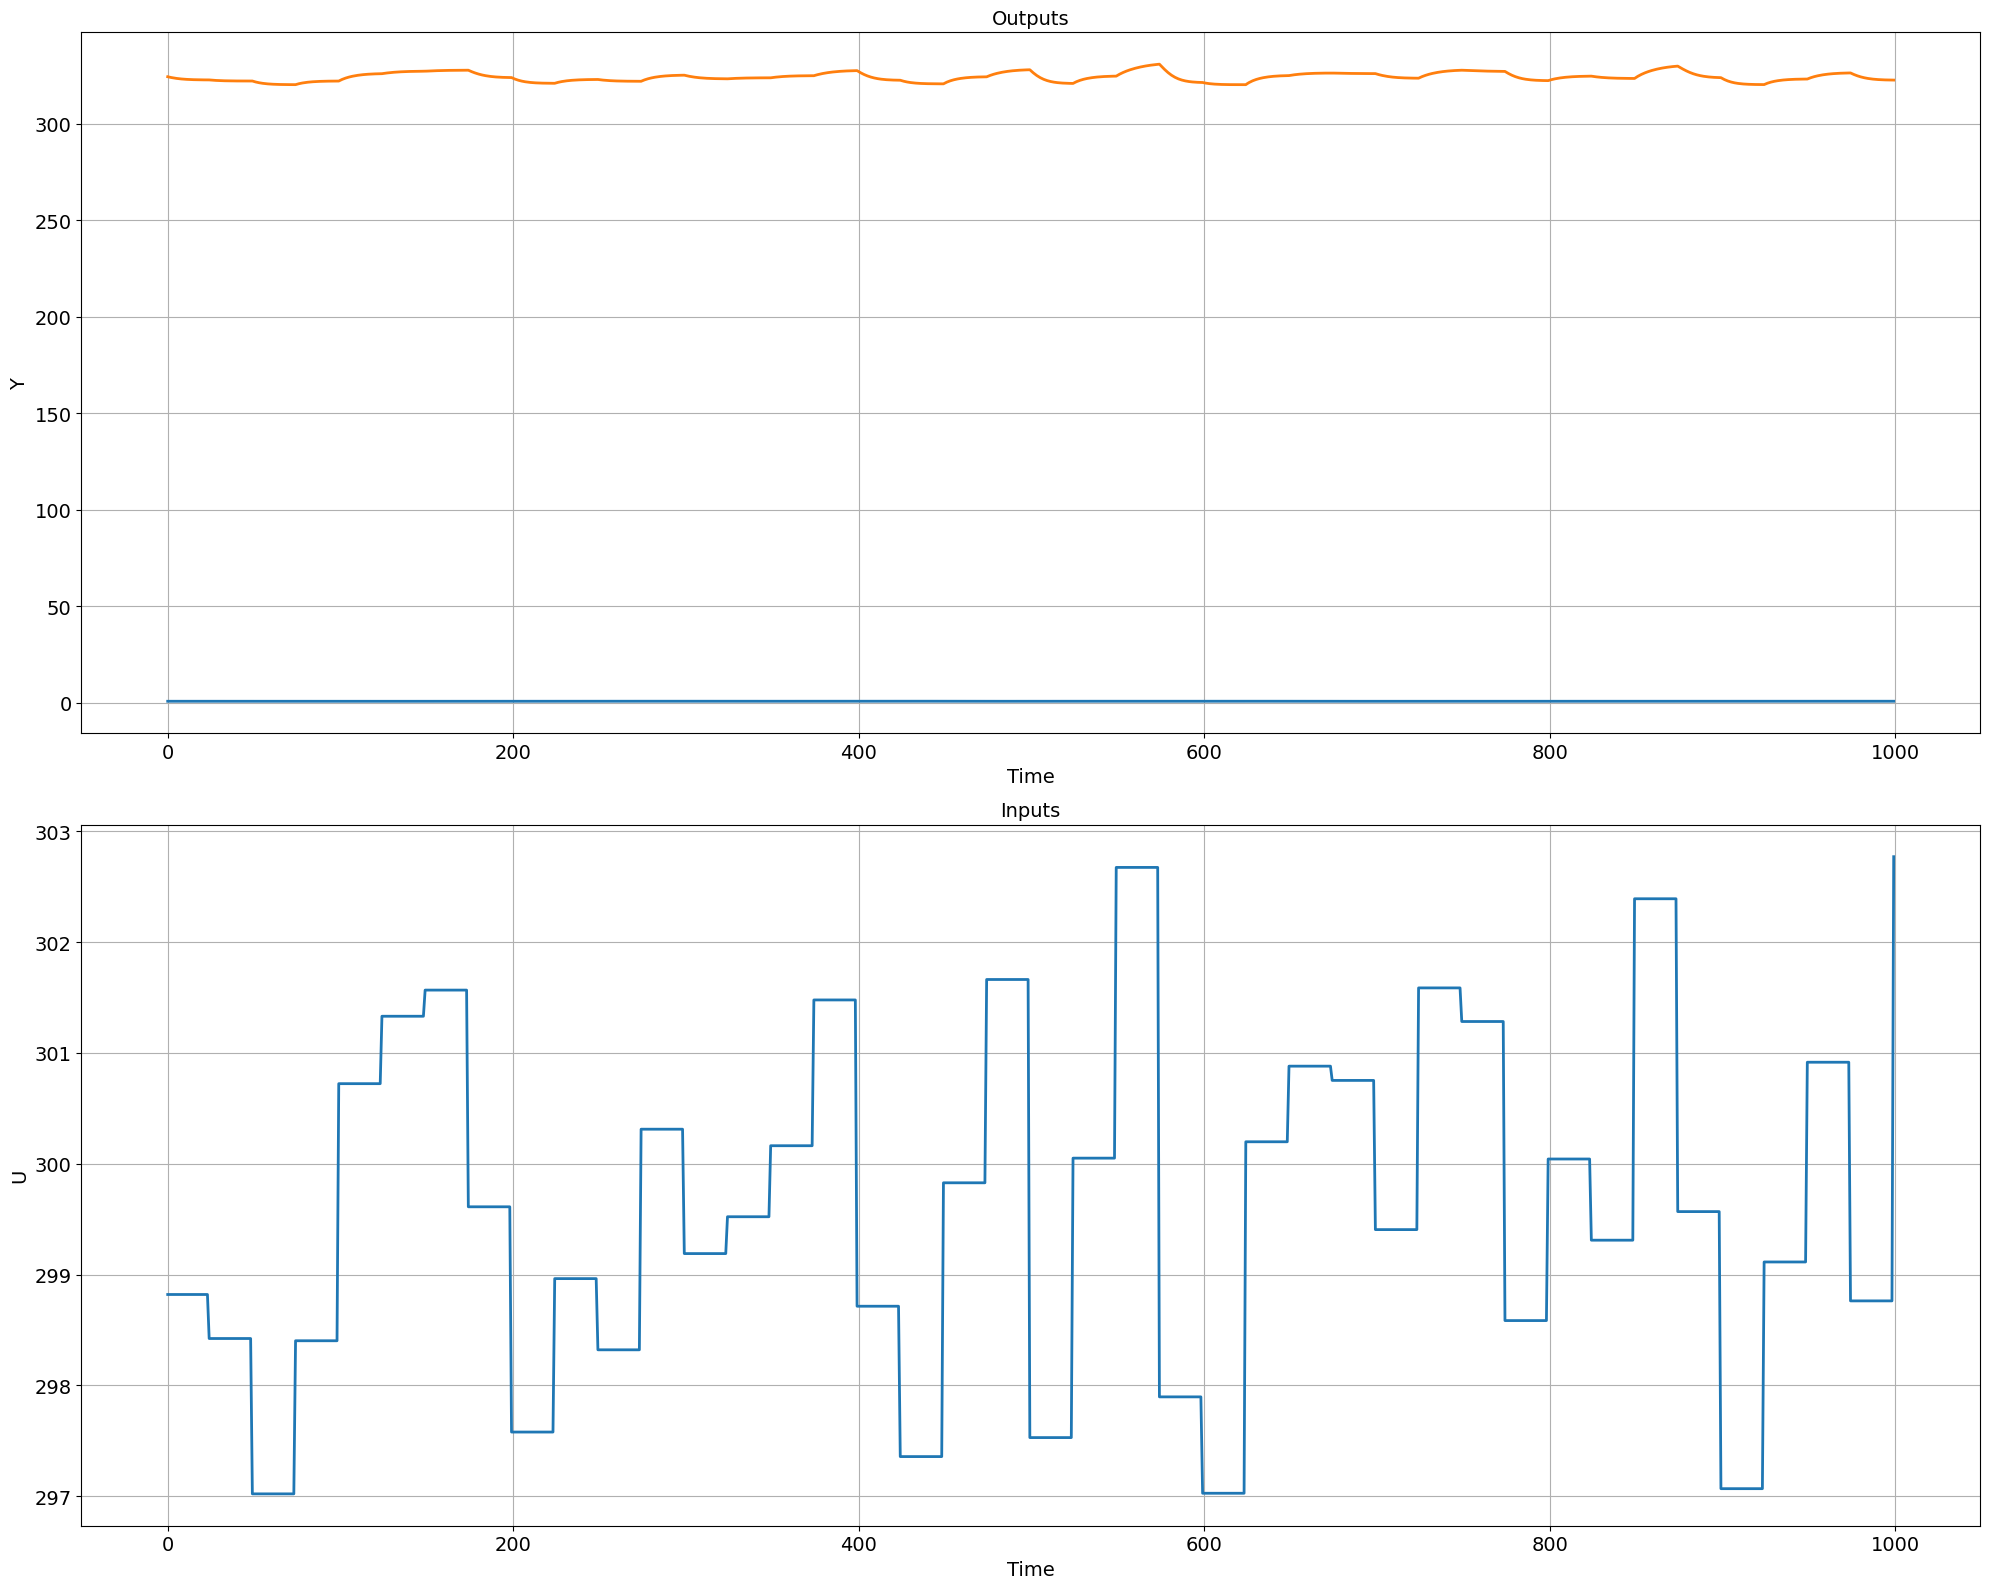

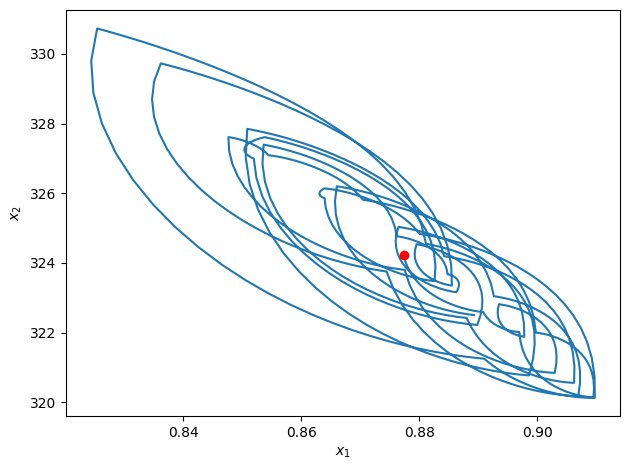

In [2]:
# %%  ground truth system
system = psl.systems['CSTR']
modelSystem = system()
ts = modelSystem.ts
nx = modelSystem.nx
ny = modelSystem.ny
nu = modelSystem.nu
raw = modelSystem.simulate(nsim=1000, ts=ts)
plot.pltOL(Y=raw['Y'], U=raw['U'])
plot.pltPhase(X=raw['Y'])


## Create training data of sampled trajectories

We will obtain a dataset of sampled trajectories of the system dynamics in the form of input-state tuples: 
$$D = \big[(u^i_0, \hat{x}^i_0), ..., (u^i_N, \hat{x}^i_{N}) \big], \, \, i \in [1, ..., m]$$
where $N$ represents the prediction horizon, $m$ represents number of measured trajectories, and $i$ represents an index of the sampled trajectory.
Variables $x_k$ represent system states, and $u_k$ are exogenous inputs at time $k$.

The **data_setup_function()** is defined here based off the base version of this notebook

In [3]:
def normalize(x, mean, std):
    return (x - mean) / std

def data_setup_function(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nu = sys.nu
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    mean_x = modelSystem.stats['Y']['mean']
    std_x = modelSystem.stats['Y']['std']
    mean_u = modelSystem.stats['U']['mean']
    std_u = modelSystem.stats['U']['std']
    

    trainX = normalize(train_sim['Y'][:length], mean_x, std_x)
    trainX = trainX.reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = normalize(train_sim['U'][:length], mean_u, std_u)
    trainU = trainU.reshape(nbatch, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data = DictDataset({'Y': trainX, 'Y0': trainX[:, 0:1, :],
                              'U': trainU}, name='train')


    devX = normalize(dev_sim['Y'][:length], mean_x, std_x)
    devX = devX.reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    devU = normalize(dev_sim['U'][:length], mean_u, std_u)
    devU = devU[:length].reshape(nbatch, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    dev_data = DictDataset({'Y': devX, 'Y0': devX[:, 0:1, :],
                            'U': devU}, name='dev')


    testX = normalize(test_sim['Y'][:length], mean_x, std_x)
    testX = testX.reshape(1, nbatch*nsteps, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    testU = normalize(test_sim['U'][:length], mean_u, std_u)
    testU = testU.reshape(1, nbatch*nsteps, nu)
    testU = torch.tensor(testU, dtype=torch.float32)
    test_data = {'Y': testX, 'Y0': testX[:, 0:1, :],
                 'U': testU}

    return train_data, dev_data, test_data, bs

In [4]:
nsim = 2000   # number of simulation steps in the dataset
nsteps = 20   # number of prediction horizon steps in the loss function
bs = 100      # minibatching batch size


## Deep Koopman model in Neuromancer

Here we construct a discrete-time encoder-decoder Koopman model with control:   

<img src="../figs/Koopman_model.png" width="500">  


Encoder: $${x}_{k} = f_y(y_k) +f_u(u_k)$$ 
Koopman: $${x}_{k+1} = K(x_k)$$ 
Decoder: $$\hat{y}_{k+1} = f_y^{-1}(x_{k+1})$$  

In [5]:
# model parameters
nx_koopman = 50
n_hidden = 60
n_layers = 2

**Encoder and Decoder networks** 

In [6]:
# instantiate output encoder neural net f_y
f_y = blocks.MLP(ny, nx_koopman, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ELU,
                 hsizes=n_layers*[n_hidden])
# initial condition encoder
encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder
encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

In [7]:
# instantiate input encoder net f_u
f_u = blocks.MLP(nu, nx_koopman, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ELU,
                 hsizes=n_layers*[n_hidden])
# initial condition encoder
encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

In [8]:
# instantiate state decoder neural net f_y_inv
f_y_inv = blocks.MLP(nx_koopman, ny, bias=True,
                linear_map=torch.nn.Linear,
                nonlin=torch.nn.ELU,
                hsizes=n_layers*[n_hidden])
# predicted trajectory decoder
decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

**Standard Koopman Operator** without stability guarantees is parametrized by linear layer of the latent size. 

**Stable Koopman Operator:**  For provably stable Koopman operator we can choose a range of linear algebra factorization that allow to constrain the eigenvalues of the resulting linear operator. 
In this example we use the following [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition) factorization of the operator given as:
$$K = U \Sigma V$$ 
$$\Sigma =  \text{diag}(\lambda_{\text{max}} - (\lambda_{\text{max}} - \lambda_{\text{min}}) \cdot \sigma(\Lambda)) $$
where $\sigma$ is logistic sigmoid activation function, $\cdot$ is a dot product, $\Lambda$ is a vector of eigenvalues of the linear operator, while $\lambda_{\text{max}}$ and $\lambda_{\text{min}}$ are constraints on maximum and minimum value of SVD factorized linear operator.

<img src="../figs/SVD_layer.png" width="300">  

In order for the SVD factorization to hold the left and right matrices $U$ and $V$, respectively, needs to be [orthogonal](https://en.wikipedia.org/wiki/Orthogonal_matrix).
This can be achieved either via [Householder reflectors](https://arxiv.org/abs/1803.09327), or via penalties in the loss function given as:  
$$\ell_{U} = || I - UU^T||_2 + || I - U^TU||_2  $$
$$\ell_{V} = || I - VV^T||_2 + || I - V^TV||_2  $$
$$\ell_{\text{stable}} = \ell_{U} + \ell_{V} $$

For more details on the SVD and other linear algebra factorizations of trainable linear layers see the references [[7]](https://ieeexplore.ieee.org/document/9482930) and [[8]](https://ieeexplore.ieee.org/abstract/document/9809789), with Pytorch implementations in the [slim submodule](https://github.com/pnnl/neuromancer/tree/master/src/neuromancer/slim) of the Neuromancer library. 

In [9]:
# instantiate Koopman operator matrix
stable = True     # if True then provably stable Koopman operator
if stable:
    # SVD factorized Koopman operator with bounded eigenvalues: sigma_min <= \lambda_i <= sigma_max
    K = slim.linear.SVDLinear(nx_koopman, nx_koopman,
                          sigma_min=0.01, sigma_max=1.0, bias=False)
    # SVD penalty variable
    K_reg_error = variable(K.reg_error())
    # SVD penalty loss term
    K_reg_loss = 1.*(K_reg_error == 0.0)
    K_reg_loss.name = 'SVD_loss'
else:
    # linear Koopman operator without guaranteed stability
    K = torch.nn.Linear(nx_koopman, nx_koopman, bias=False)

Below is the base class for Koopman control. Note that if we want to use any hardcoded tensors, one would need to have this class inherit from **pl.LightningModule** and use **type_as()**. Please refer to Part_1_stabilize_linear_system_lightning.ipynb notebook for more information 

In [10]:
class Koopman_control(nn.Module):
    """
    Baseline class for Koopman control model
    Implements discrete-time dynamical system:
        x_k+1 = K x_k + u_k
    with variables:
        x_k - latent states
        u_k - latent control inputs
    """

    def __init__(self, K):
        super().__init__()
        self.K = K

    def forward(self, x, u):
        """
        :param x: (torch.Tensor, shape=[batchsize, nx])
        :param u: (torch.Tensor, shape=[batchsize, nx])
        :return: (torch.Tensor, shape=[batchsize, nx])
        """
        x = self.K(x) + u
        return x

In [12]:
# symbolic Koopman model with control inputs
Koopman = Node(Koopman_control(K), ['x', 'u_latent'], ['x'], name='K')

# latent Koopmann rollout
dynamics_model = System([Koopman], name='Koopman', nsteps=nsteps)

In [12]:
# dynamics_model.show()

In [13]:
# put all nodes of the Koopman model together in a list of nodes
nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]

## Define Koopman system identification loss function terms

Here we define loss function terms to fit the encoded-decoder Koopman parameters $\theta$ from given time-series data.
The loss function terms follow the implementation as given in the reference [[2]](https://www.nature.com/articles/s41467-018-07210-0). 

**Output trajectory prediction loss:**  
$$\ell_y = \sum_{k=1}^{N} Q_y||y^i_{k+1} - \hat{y}^i_{k+1}||_2^2$$ 
**One step output prediction loss:**  
$$\ell_{y_1} = Q_{y_1}||y^i_2 - \hat{y}^i_2||_2^2$$ 

where $\hat{y}^i_{k+1} = \phi^{-1}_{\theta_3}(K^k_{\theta_2}(\phi_{\theta_1}(y^i_1))) $, 
and $N$ is defining length of the rollout (prediction) horizon.  

**Latent trajectory prediction loss:**  
$$\ell_{\text{lin}} = \sum_{k=1}^{N}  Q_x||\phi_{\theta_1}(y_{k+1}^i) - K^k\phi_{\theta_1}(y_1^i)||_2^2$$ 


In [14]:
# variables
Y = variable("Y")  # observed
yhat = variable('yhat')  # predicted output
x_latent = variable('x_latent')  # encoded output trajectory in the latent space
u_latent = variable('u_latent')  # encoded input trajectory in the latent space
x = variable('x')  # Koopman latent space trajectory

xu_latent = x_latent + u_latent  # latent state trajectory

# output trajectory tracking loss
y_loss = 10. * (yhat[:, 1:-1, :] == Y[:, 1:, :]) ^ 2
y_loss.name = "y_loss"

# one-step tracking loss
onestep_loss = 1.*(yhat[:, 1, :] == Y[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# latent trajectory tracking loss
x_loss = 1. * (x[:, 1:-1, :] == xu_latent[:, 1:, :]) ^ 2
x_loss.name = "x_loss"


## Construct System ID learning problem

Given the training dataset $\hat{X} = [\hat{x}^i_0, ..., \hat{x}^i_{N}]$ we want to solve the following problem:
 
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m \Big( \ell_{y} + \ell_{y_1}  +\ell_{\text{lin}} + \ell_{\text{recon}} + \ell_{\text{stable}} \Big) \\
&\text{subject to}    && \hat{y}^i_{k+1} = \phi^{-1}_{\theta_3}(K^k_{\theta_2}(\phi_{\theta_1}(y_1^i))) \\
\end{align}
$$  

In [15]:
# aggregate list of objective terms and constraints
objectives = [y_loss, x_loss, onestep_loss]

if stable:
    objectives.append(K_reg_loss)

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints=[])

# construct constrained optimization problem
problem = Problem(nodes, loss)

In [16]:
# plot computational graph
# problem.show()

### Tensorboard Visualization

We can invoke tensorboard directly using the following commands, as Lightning automatically will log training history to *lightning_logs*. The latest "version" should correspond to the most current training run

In [17]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

In [18]:
lit_data_module = LitDataModule(data_setup_function=data_setup_function, sys=modelSystem, nsim=nsim, nsteps=nsteps,ts=ts, bs=bs)
lit_trainer = LitTrainer(epochs=2000,accelerator='gpu', devices=[1])
best_problem_weights_path = lit_trainer.fit(problem, lit_data_module)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


{'sys': CSTR(), 'nsim': 2000, 'nsteps': 20, 'ts': 0.1, 'bs': 100}


/home/birm560/miniconda3/envs/neuromancer3/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory ./ exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type    | Params
------------------------------------
0 | problem | Problem | 25.7 K
------------------------------------
25.7 K    Trainable params
0         Non-trainable params
25.7 K    Total params
0.103     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.91it/s]VAL EPOCH AVERAGE  tensor(0.4665, device='cuda:1', grad_fn=<MeanBackward0>)
                                                                            

/home/birm560/miniconda3/envs/neuromancer3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.
/home/birm560/miniconda3/envs/neuromancer3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.
/home/birm560/miniconda3/envs/neuromancer3/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.76it/s, v_num=81]

Epoch 0, global step 1: 'dev_loss' reached 0.61740 (best 0.61740), saving model to './epoch=0-step=1.ckpt' as top 1


EPOCH AVERAGE  tensor(0.5291, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 15.39it/s, v_num=81]

Epoch 1, global step 2: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.7220, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 13.39it/s, v_num=81]EPOCH AVERAGE  tensor(0.6432, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 2, global step 3: 'dev_loss' was not in top 1


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s, v_num=81]EPOCH AVERAGE  tensor(0.9273, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 3, global step 4: 'dev_loss' reached 0.39920 (best 0.39920), saving model to './epoch=3-step=4.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s, v_num=81]EPOCH AVERAGE  tensor(0.4370, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 4, global step 5: 'dev_loss' was not in top 1


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s, v_num=81]EPOCH AVERAGE  tensor(0.5792, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 5, global step 6: 'dev_loss' was not in top 1


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 13.87it/s, v_num=81]EPOCH AVERAGE  tensor(0.4655, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 6, global step 7: 'dev_loss' was not in top 1


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 14.77it/s, v_num=81]EPOCH AVERAGE  tensor(0.7091, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 7, global step 8: 'dev_loss' was not in top 1


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 13.85it/s, v_num=81]

Epoch 8, global step 9: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4319, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 13.61it/s, v_num=81]EPOCH AVERAGE  

Epoch 9, global step 10: 'dev_loss' was not in top 1


tensor(0.7406, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 14.70it/s, v_num=81]

Epoch 10, global step 11: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5192, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 14.10it/s, v_num=81]EPOCH AVERAGE  tensor(0.8815, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 11, global step 12: 'dev_loss' reached 0.39195 (best 0.39195), saving model to './epoch=11-step=12.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 13.76it/s, v_num=81]

Epoch 12, global step 13: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4027, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 14.56it/s, v_num=81]

Epoch 13, global step 14: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5553, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 13.20it/s, v_num=81]

Epoch 14, global step 15: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4871, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 14.62it/s, v_num=81]EPOCH AVERAGE  tensor(0.8599, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 15, global step 16: 'dev_loss' was not in top 1


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 14.45it/s, v_num=81]EPOCH AVERAGE  tensor(0.3957, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 16, global step 17: 'dev_loss' was not in top 1


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s, v_num=81]

Epoch 17, global step 18: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5108, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s, v_num=81]EPOCH AVERAGE  tensor(0.4961, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 18, global step 19: 'dev_loss' was not in top 1


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 14.43it/s, v_num=81]

Epoch 19, global step 20: 'dev_loss' reached 0.37610 (best 0.37610), saving model to './epoch=19-step=20.ckpt' as top 1


EPOCH AVERAGE  tensor(0.8654, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s, v_num=81]EPOCH AVERAGE  tensor(0.3693, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 20, global step 21: 'dev_loss' reached 0.35028 (best 0.35028), saving model to './epoch=20-step=21.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 15.21it/s, v_num=81]EPOCH AVERAGE  tensor(0.4158, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 21, global step 22: 'dev_loss' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s, v_num=81]

Epoch 22, global step 23: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3819, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 15.17it/s, v_num=81]

Epoch 23, global step 24: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5798, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s, v_num=81]

Epoch 24, global step 25: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4108, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 13.41it/s, v_num=81]

Epoch 25, global step 26: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.7232, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s, v_num=81]

Epoch 26, global step 27: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5963, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 15.15it/s, v_num=81]

Epoch 27, global step 28: 'dev_loss' reached 0.32723 (best 0.32723), saving model to './epoch=27-step=28.ckpt' as top 1


EPOCH AVERAGE  tensor(1.3083, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s, v_num=81]

Epoch 28, global step 29: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3336, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s, v_num=81]

Epoch 29, global step 30: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3851, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 14.44it/s, v_num=81]

Epoch 30, global step 31: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3586, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 13.45it/s, v_num=81]EPOCH AVERAGE  tensor(0.5524, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 31, global step 32: 'dev_loss' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s, v_num=81]EPOCH AVERAGE  tensor(0.4613, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 32, global step 33: 'dev_loss' was not in top 1


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 13.51it/s, v_num=81]

Epoch 33, global step 34: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.8758, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s, v_num=81]

Epoch 34, global step 35: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4272, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s, v_num=81]EPOCH AVERAGE  tensor(0.6158, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 35, global step 36: 'dev_loss' was not in top 1


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 13.15it/s, v_num=81]EPOCH AVERAGE  tensor(0.4565, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 36, global step 37: 'dev_loss' was not in top 1


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 13.63it/s, v_num=81]

Epoch 37, global step 38: 'dev_loss' reached 0.32180 (best 0.32180), saving model to './epoch=37-step=38.ckpt' as top 1


EPOCH AVERAGE  tensor(0.8152, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 13.42it/s, v_num=81]

Epoch 38, global step 39: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3122, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s, v_num=81]

Epoch 39, global step 40: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3937, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 13.34it/s, v_num=81]EPOCH AVERAGE  tensor(0.3706, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 40, global step 41: 'dev_loss' was not in top 1


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 15.78it/s, v_num=81]

Epoch 41, global step 42: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.6640, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 13.20it/s, v_num=81]

Epoch 42, global step 43: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3774, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 13.49it/s, v_num=81]

Epoch 43, global step 44: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.7413, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s, v_num=81]EPOCH AVERAGE  tensor(0.5674, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 44, global step 45: 'dev_loss' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 14.69it/s, v_num=81]

Epoch 45, global step 46: 'dev_loss' reached 0.31071 (best 0.31071), saving model to './epoch=45-step=46.ckpt' as top 1


EPOCH AVERAGE  tensor(0.9686, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 13.51it/s, v_num=81]

Epoch 46, global step 47: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3087, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 14.66it/s, v_num=81]EPOCH AVERAGE  tensor(0.4060, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 47, global step 48: 'dev_loss' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 13.75it/s, v_num=81]EPOCH AVERAGE  tensor(0.4816, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 48, global step 49: 'dev_loss' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s, v_num=81]EPOCH AVERAGE  tensor(0.7354, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 49, global step 50: 'dev_loss' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s, v_num=81]EPOCH AVERAGE  

Epoch 50, global step 51: 'dev_loss' was not in top 1


tensor(0.3801, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 16.03it/s, v_num=81]EPOCH AVERAGE  tensor(0.4808, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 51, global step 52: 'dev_loss' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 13.43it/s, v_num=81]EPOCH AVERAGE  tensor(0.4620, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 52, global step 53: 'dev_loss' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 15.20it/s, v_num=81]EPOCH AVERAGE  tensor(0.8824, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 53, global step 54: 'dev_loss' reached 0.26699 (best 0.26699), saving model to './epoch=53-step=54.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s, v_num=81]

Epoch 54, global step 55: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2579, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 14.69it/s, v_num=81]

Epoch 55, global step 56: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3077, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s, v_num=81]EPOCH AVERAGE  tensor(0.3434, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 56, global step 57: 'dev_loss' was not in top 1


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s, v_num=81]

Epoch 57, global step 58: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.6534, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s, v_num=81]

Epoch 58, global step 59: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4215, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 14.46it/s, v_num=81]EPOCH AVERAGE  tensor(0.7897, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 59, global step 60: 'dev_loss' was not in top 1


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 13.49it/s, v_num=81]

Epoch 60, global step 61: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3961, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s, v_num=81]

Epoch 61, global step 62: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.6647, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s, v_num=81]EPOCH AVERAGE  tensor(0.4876, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 62, global step 63: 'dev_loss' was not in top 1


Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 13.83it/s, v_num=81]EPOCH AVERAGE  tensor(0.6507, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 63, global step 64: 'dev_loss' was not in top 1


Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s, v_num=81]EPOCH AVERAGE  tensor(0.3576, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 64, global step 65: 'dev_loss' was not in top 1


Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s, v_num=81]

Epoch 65, global step 66: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4264, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s, v_num=81]

Epoch 66, global step 67: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3809, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 67: 100%|██████████| 1/1 [00:00<00:00,  9.73it/s, v_num=81]

Epoch 67, global step 68: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.7415, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s, v_num=81]

Epoch 68, global step 69: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2973, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 14.49it/s, v_num=81]

Epoch 69, global step 70: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4355, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 15.25it/s, v_num=81]EPOCH AVERAGE  tensor(0.3673, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 70, global step 71: 'dev_loss' was not in top 1


Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 13.29it/s, v_num=81]EPOCH AVERAGE  tensor(0.6737, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 71, global step 72: 'dev_loss' was not in top 1


Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s, v_num=81]EPOCH AVERAGE  tensor(0.3753, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 72, global step 73: 'dev_loss' was not in top 1


Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s, v_num=81]EPOCH AVERAGE  tensor(0.6629, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 73, global step 74: 'dev_loss' was not in top 1


Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 14.74it/s, v_num=81]EPOCH AVERAGE  tensor(0.3858, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 74, global step 75: 'dev_loss' was not in top 1


Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 13.50it/s, v_num=81]EPOCH AVERAGE  tensor(0.6894, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 75, global step 76: 'dev_loss' was not in top 1


Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 15.89it/s, v_num=81]EPOCH AVERAGE  tensor(0.4691, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 76, global step 77: 'dev_loss' was not in top 1


Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 13.85it/s, v_num=81]

Epoch 77, global step 78: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.6307, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 16.10it/s, v_num=81]

Epoch 78, global step 79: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4675, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s, v_num=81]

Epoch 79, global step 80: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5282, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 15.16it/s, v_num=81]

Epoch 80, global step 81: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3218, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 15.20it/s, v_num=81]

Epoch 81, global step 82: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5482, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s, v_num=81]EPOCH AVERAGE  tensor(0.3134, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 82, global step 83: 'dev_loss' was not in top 1


Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 13.28it/s, v_num=81]

Epoch 83, global step 84: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5245, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 15.05it/s, v_num=81]EPOCH AVERAGE  tensor(0.3048, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 84, global step 85: 'dev_loss' was not in top 1


Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 13.13it/s, v_num=81]EPOCH AVERAGE  tensor(0.5371, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 85, global step 86: 'dev_loss' was not in top 1


Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 14.97it/s, v_num=81]EPOCH AVERAGE  tensor(0.3734, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 86, global step 87: 'dev_loss' was not in top 1


Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 14.70it/s, v_num=81]

Epoch 87, global step 88: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.7046, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 14.63it/s, v_num=81]EPOCH AVERAGE  tensor(0.3546, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 88, global step 89: 'dev_loss' was not in top 1


Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s, v_num=81]

Epoch 89, global step 90: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5697, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 16.26it/s, v_num=81]EPOCH AVERAGE  tensor(0.3774, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 90, global step 91: 'dev_loss' was not in top 1


Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 13.71it/s, v_num=81]EPOCH AVERAGE  tensor(0.5623, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 91, global step 92: 'dev_loss' was not in top 1


Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s, v_num=81]

Epoch 92, global step 93: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4505, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 15.62it/s, v_num=81]EPOCH AVERAGE  tensor(0.4899, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 93, global step 94: 'dev_loss' was not in top 1


Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 14.33it/s, v_num=81]

Epoch 94, global step 95: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3896, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s, v_num=81]

Epoch 95, global step 96: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.6150, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s, v_num=81]EPOCH AVERAGE  tensor(0.3135, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 96, global step 97: 'dev_loss' was not in top 1


Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 15.39it/s, v_num=81]EPOCH AVERAGE  tensor(0.4767, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 97, global step 98: 'dev_loss' was not in top 1


Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 13.39it/s, v_num=81]EPOCH AVERAGE  tensor(0.2593, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 98, global step 99: 'dev_loss' was not in top 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s, v_num=81]EPOCH AVERAGE  tensor(0.4131, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 99, global step 100: 'dev_loss' was not in top 1


Epoch 100: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s, v_num=81]EPOCH AVERAGE  tensor(0.3370, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 100, global step 101: 'dev_loss' was not in top 1


Epoch 101: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s, v_num=81]EPOCH AVERAGE  tensor(0.7863, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 101, global step 102: 'dev_loss' was not in top 1


Epoch 102: 100%|██████████| 1/1 [00:00<00:00, 13.62it/s, v_num=81]

Epoch 102, global step 103: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4547, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 103: 100%|██████████| 1/1 [00:00<00:00, 15.56it/s, v_num=81]EPOCH AVERAGE  tensor(0.7519, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 103, global step 104: 'dev_loss' was not in top 1


Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 13.74it/s, v_num=81]EPOCH AVERAGE  tensor(0.2789, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 104, global step 105: 'dev_loss' was not in top 1


Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 14.47it/s, v_num=81]

Epoch 105, global step 106: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3993, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 106: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s, v_num=81]

Epoch 106, global step 107: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2925, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 16.11it/s, v_num=81]EPOCH AVERAGE  tensor(0.5226, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 107, global step 108: 'dev_loss' was not in top 1


Epoch 108: 100%|██████████| 1/1 [00:00<00:00, 13.42it/s, v_num=81]EPOCH AVERAGE  tensor(0.6134, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 108, global step 109: 'dev_loss' was not in top 1


Epoch 109: 100%|██████████| 1/1 [00:00<00:00, 13.93it/s, v_num=81]

Epoch 109, global step 110: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.6802, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 110: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s, v_num=81]

Epoch 110, global step 111: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2849, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 13.44it/s, v_num=81]

Epoch 111, global step 112: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4140, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 112: 100%|██████████| 1/1 [00:00<00:00, 14.62it/s, v_num=81]EPOCH AVERAGE  tensor(0.3046, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 112, global step 113: 'dev_loss' was not in top 1


Epoch 113: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s, v_num=81]

Epoch 113, global step 114: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5613, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s, v_num=81]

Epoch 114, global step 115: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2702, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 115: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s, v_num=81]

Epoch 115, global step 116: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4800, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 116: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s, v_num=81]EPOCH AVERAGE  tensor(0.3558, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 116, global step 117: 'dev_loss' was not in top 1


Epoch 117: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s, v_num=81]EPOCH AVERAGE  tensor(0.6503, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 117, global step 118: 'dev_loss' was not in top 1


Epoch 118: 100%|██████████| 1/1 [00:00<00:00, 13.29it/s, v_num=81]

Epoch 118, global step 119: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3497, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 15.18it/s, v_num=81]EPOCH AVERAGE  tensor(0.5456, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 119, global step 120: 'dev_loss' was not in top 1


Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s, v_num=81]

Epoch 120, global step 121: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4670, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 121: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s, v_num=81]

Epoch 121, global step 122: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4736, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 122: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s, v_num=81]

Epoch 122, global step 123: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3010, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 123: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s, v_num=81]

Epoch 123, global step 124: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5036, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 124: 100%|██████████| 1/1 [00:00<00:00, 16.94it/s, v_num=81]

Epoch 124, global step 125: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3159, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 125: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s, v_num=81]EPOCH AVERAGE  tensor(0.5495, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 125, global step 126: 'dev_loss' was not in top 1


Epoch 126: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s, v_num=81]

Epoch 126, global step 127: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2527, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 127: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s, v_num=81]EPOCH AVERAGE  tensor(0.4224, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 127, global step 128: 'dev_loss' was not in top 1


Epoch 128: 100%|██████████| 1/1 [00:00<00:00, 13.21it/s, v_num=81]

Epoch 128, global step 129: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3490, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s, v_num=81]EPOCH AVERAGE  tensor(0.6898, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 129, global step 130: 'dev_loss' was not in top 1


Epoch 130: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s, v_num=81]

Epoch 130, global step 131: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3269, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 131: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s, v_num=81]

Epoch 131, global step 132: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5579, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 132: 100%|██████████| 1/1 [00:00<00:00, 13.64it/s, v_num=81]

Epoch 132, global step 133: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3764, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 133: 100%|██████████| 1/1 [00:00<00:00, 15.21it/s, v_num=81]

Epoch 133, global step 134: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5579, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 134: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s, v_num=81]

Epoch 134, global step 135: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5345, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 135: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s, v_num=81]

Epoch 135, global step 136: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4663, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 136: 100%|██████████| 1/1 [00:00<00:00, 14.02it/s, v_num=81]

Epoch 136, global step 137: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3124, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 137: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s, v_num=81]EPOCH AVERAGE  tensor(0.4852, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 137, global step 138: 'dev_loss' was not in top 1


Epoch 138: 100%|██████████| 1/1 [00:00<00:00, 13.87it/s, v_num=81]EPOCH AVERAGE  tensor(0.2654, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 138, global step 139: 'dev_loss' was not in top 1


Epoch 139: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s, v_num=81]EPOCH AVERAGE  tensor(0.4414, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 139, global step 140: 'dev_loss' was not in top 1


Epoch 140: 100%|██████████| 1/1 [00:00<00:00, 13.21it/s, v_num=81]

Epoch 140, global step 141: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2612, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 141: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s, v_num=81]

Epoch 141, global step 142: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4987, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 142: 100%|██████████| 1/1 [00:00<00:00, 14.74it/s, v_num=81]

Epoch 142, global step 143: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3567, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 143: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s, v_num=81]EPOCH AVERAGE  tensor(0.6875, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 143, global step 144: 'dev_loss' was not in top 1


Epoch 144: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s, v_num=81]EPOCH AVERAGE  

Epoch 144, global step 145: 'dev_loss' was not in top 1


tensor(0.2889, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 145: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s, v_num=81]

Epoch 145, global step 146: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4431, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 146: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s, v_num=81]

Epoch 146, global step 147: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3163, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 147: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s, v_num=81]

Epoch 147, global step 148: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5066, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 148: 100%|██████████| 1/1 [00:00<00:00, 16.29it/s, v_num=81]EPOCH AVERAGE  tensor(0.5421, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 148, global step 149: 'dev_loss' was not in top 1


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s, v_num=81]

Epoch 149, global step 150: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5132, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 150: 100%|██████████| 1/1 [00:00<00:00, 14.73it/s, v_num=81]

Epoch 150, global step 151: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3378, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 151: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s, v_num=81]EPOCH AVERAGE  tensor(0.5176, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 151, global step 152: 'dev_loss' reached 0.26446 (best 0.26446), saving model to './epoch=151-step=152.ckpt' as top 1


Epoch 152: 100%|██████████| 1/1 [00:00<00:00, 14.56it/s, v_num=81]EPOCH AVERAGE  tensor(0.2422, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 152, global step 153: 'dev_loss' was not in top 1


Epoch 153: 100%|██████████| 1/1 [00:00<00:00, 13.73it/s, v_num=81]EPOCH AVERAGE  tensor(0.3807, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 153, global step 154: 'dev_loss' reached 0.25235 (best 0.25235), saving model to './epoch=153-step=154.ckpt' as top 1


Epoch 154: 100%|██████████| 1/1 [00:00<00:00, 13.79it/s, v_num=81]EPOCH AVERAGE  tensor(0.2333, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 154, global step 155: 'dev_loss' was not in top 1


Epoch 155: 100%|██████████| 1/1 [00:00<00:00, 13.98it/s, v_num=81]EPOCH AVERAGE  tensor(0.4641, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 155, global step 156: 'dev_loss' was not in top 1


Epoch 156: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s, v_num=81]

Epoch 156, global step 157: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4177, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 157: 100%|██████████| 1/1 [00:00<00:00, 13.54it/s, v_num=81]

Epoch 157, global step 158: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.8355, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 158: 100%|██████████| 1/1 [00:00<00:00, 13.25it/s, v_num=81]EPOCH AVERAGE  tensor(0.2570, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 158, global step 159: 'dev_loss' was not in top 1


Epoch 159: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s, v_num=81]

Epoch 159, global step 160: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3715, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 160: 100%|██████████| 1/1 [00:00<00:00, 13.64it/s, v_num=81]

Epoch 160, global step 161: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3147, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 161: 100%|██████████| 1/1 [00:00<00:00, 15.11it/s, v_num=81]EPOCH AVERAGE  tensor(0.4890, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 161, global step 162: 'dev_loss' was not in top 1


Epoch 162: 100%|██████████| 1/1 [00:00<00:00, 13.94it/s, v_num=81]

Epoch 162, global step 163: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5252, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 163: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s, v_num=81]EPOCH AVERAGE  tensor(0.5035, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 163, global step 164: 'dev_loss' was not in top 1


Epoch 164: 100%|██████████| 1/1 [00:00<00:00, 14.52it/s, v_num=81]

Epoch 164, global step 165: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2931, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 165: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s, v_num=81]

Epoch 165, global step 166: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4806, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 166: 100%|██████████| 1/1 [00:00<00:00, 13.37it/s, v_num=81]

Epoch 166, global step 167: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2412, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 167: 100%|██████████| 1/1 [00:00<00:00, 14.10it/s, v_num=81]EPOCH AVERAGE  tensor(0.4297, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 167, global step 168: 'dev_loss' was not in top 1


Epoch 168: 100%|██████████| 1/1 [00:00<00:00, 13.92it/s, v_num=81]EPOCH AVERAGE  tensor(0.3008, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 168, global step 169: 'dev_loss' was not in top 1


Epoch 169: 100%|██████████| 1/1 [00:00<00:00, 15.04it/s, v_num=81]

Epoch 169, global step 170: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5748, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 170: 100%|██████████| 1/1 [00:00<00:00, 13.76it/s, v_num=81]EPOCH AVERAGE  tensor(0.2997, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 170, global step 171: 'dev_loss' was not in top 1


Epoch 171: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s, v_num=81]

Epoch 171, global step 172: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5089, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 172: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s, v_num=81]

Epoch 172, global step 173: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3537, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 173: 100%|██████████| 1/1 [00:00<00:00, 15.19it/s, v_num=81]

Epoch 173, global step 174: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5425, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 174: 100%|██████████| 1/1 [00:00<00:00, 13.51it/s, v_num=81]EPOCH AVERAGE  tensor(0.4777, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 174, global step 175: 'dev_loss' was not in top 1


Epoch 175: 100%|██████████| 1/1 [00:00<00:00, 15.09it/s, v_num=81]EPOCH AVERAGE  

Epoch 175, global step 176: 'dev_loss' was not in top 1


tensor(0.4253, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 176: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s, v_num=81]EPOCH AVERAGE  tensor(0.3036, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 176, global step 177: 'dev_loss' was not in top 1


Epoch 177: 100%|██████████| 1/1 [00:00<00:00, 15.29it/s, v_num=81]EPOCH AVERAGE  tensor(0.5028, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 177, global step 178: 'dev_loss' was not in top 1


Epoch 178: 100%|██████████| 1/1 [00:00<00:00, 13.70it/s, v_num=81]

Epoch 178, global step 179: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2342, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 179: 100%|██████████| 1/1 [00:00<00:00, 14.40it/s, v_num=81]

Epoch 179, global step 180: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3669, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 180: 100%|██████████| 1/1 [00:00<00:00, 13.60it/s, v_num=81]EPOCH AVERAGE  tensor(0.2373, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 180, global step 181: 'dev_loss' was not in top 1


Epoch 181: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s, v_num=81]

Epoch 181, global step 182: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4614, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 182: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s, v_num=81]

Epoch 182, global step 183: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3698, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 183: 100%|██████████| 1/1 [00:00<00:00, 13.84it/s, v_num=81]EPOCH AVERAGE  tensor(0.7458, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 183, global step 184: 'dev_loss' was not in top 1


Epoch 184: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s, v_num=81]

Epoch 184, global step 185: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2841, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 185: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s, v_num=81]EPOCH AVERAGE  tensor(0.4218, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 185, global step 186: 'dev_loss' was not in top 1


Epoch 186: 100%|██████████| 1/1 [00:00<00:00, 13.64it/s, v_num=81]

Epoch 186, global step 187: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2925, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 187: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s, v_num=81]

Epoch 187, global step 188: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4448, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 188: 100%|██████████| 1/1 [00:00<00:00, 14.33it/s, v_num=81]EPOCH AVERAGE  tensor(0.5162, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 188, global step 189: 'dev_loss' was not in top 1


Epoch 189: 100%|██████████| 1/1 [00:00<00:00, 15.49it/s, v_num=81]

Epoch 189, global step 190: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4866, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 190: 100%|██████████| 1/1 [00:00<00:00, 13.83it/s, v_num=81]EPOCH AVERAGE  tensor(0.2972, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 190, global step 191: 'dev_loss' was not in top 1


Epoch 191: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s, v_num=81]

Epoch 191, global step 192: 'dev_loss' reached 0.25188 (best 0.25188), saving model to './epoch=191-step=192.ckpt' as top 1


EPOCH AVERAGE  tensor(0.4588, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 192: 100%|██████████| 1/1 [00:00<00:00, 14.66it/s, v_num=81]

Epoch 192, global step 193: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2299, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 193: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s, v_num=81]

Epoch 193, global step 194: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3990, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 194: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s, v_num=81]

Epoch 194, global step 195: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2690, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 195: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s, v_num=81]

Epoch 195, global step 196: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5615, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 196: 100%|██████████| 1/1 [00:00<00:00, 14.67it/s, v_num=81]

Epoch 196, global step 197: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3321, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 197: 100%|██████████| 1/1 [00:00<00:00, 13.74it/s, v_num=81]EPOCH AVERAGE  tensor(0.5606, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 197, global step 198: 'dev_loss' was not in top 1


Epoch 198: 100%|██████████| 1/1 [00:00<00:00, 15.86it/s, v_num=81]

Epoch 198, global step 199: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2871, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s, v_num=81]

Epoch 199, global step 200: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4477, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 200: 100%|██████████| 1/1 [00:00<00:00, 15.34it/s, v_num=81]EPOCH AVERAGE  tensor(0.4433, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 200, global step 201: 'dev_loss' was not in top 1


Epoch 201: 100%|██████████| 1/1 [00:00<00:00, 13.58it/s, v_num=81]EPOCH AVERAGE  tensor(0.4747, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 201, global step 202: 'dev_loss' was not in top 1


Epoch 202: 100%|██████████| 1/1 [00:00<00:00, 13.94it/s, v_num=81]EPOCH AVERAGE  tensor(0.3670, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 202, global step 203: 'dev_loss' was not in top 1


Epoch 203: 100%|██████████| 1/1 [00:00<00:00, 16.14it/s, v_num=81]

Epoch 203, global step 204: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4655, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 204: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s, v_num=81]EPOCH AVERAGE  

Epoch 204, global step 205: 'dev_loss' was not in top 1


tensor(0.2488, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 205: 100%|██████████| 1/1 [00:00<00:00, 15.16it/s, v_num=81]

Epoch 205, global step 206: 'dev_loss' reached 0.23294 (best 0.23294), saving model to './epoch=205-step=206.ckpt' as top 1


EPOCH AVERAGE  tensor(0.4066, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 206: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s, v_num=81]EPOCH AVERAGE  tensor(0.2135, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 206, global step 207: 'dev_loss' was not in top 1


Epoch 207: 100%|██████████| 1/1 [00:00<00:00, 15.15it/s, v_num=81]EPOCH AVERAGE  tensor(0.3843, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 207, global step 208: 'dev_loss' was not in top 1


Epoch 208: 100%|██████████| 1/1 [00:00<00:00, 13.28it/s, v_num=81]EPOCH AVERAGE  

Epoch 208, global step 209: 'dev_loss' was not in top 1


tensor(0.3184, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 209: 100%|██████████| 1/1 [00:00<00:00, 15.60it/s, v_num=81]EPOCH AVERAGE  

Epoch 209, global step 210: 'dev_loss' was not in top 1


tensor(0.6743, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 210: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s, v_num=81]EPOCH AVERAGE  tensor(0.2973, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 210, global step 211: 'dev_loss' was not in top 1


Epoch 211: 100%|██████████| 1/1 [00:00<00:00, 15.95it/s, v_num=81]

Epoch 211, global step 212: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4675, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 212: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s, v_num=81]

Epoch 212, global step 213: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2937, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 213: 100%|██████████| 1/1 [00:00<00:00, 15.84it/s, v_num=81]EPOCH AVERAGE  tensor(0.4375, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 213, global step 214: 'dev_loss' was not in top 1


Epoch 214: 100%|██████████| 1/1 [00:00<00:00, 13.94it/s, v_num=81]EPOCH AVERAGE  tensor(0.4803, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 214, global step 215: 'dev_loss' was not in top 1


Epoch 215: 100%|██████████| 1/1 [00:00<00:00, 15.66it/s, v_num=81]EPOCH AVERAGE  tensor(0.4733, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 215, global step 216: 'dev_loss' was not in top 1


Epoch 216: 100%|██████████| 1/1 [00:00<00:00, 13.84it/s, v_num=81]EPOCH AVERAGE  tensor(0.3111, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 216, global step 217: 'dev_loss' was not in top 1


Epoch 217: 100%|██████████| 1/1 [00:00<00:00, 13.44it/s, v_num=81]

Epoch 217, global step 218: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4415, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 218: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s, v_num=81]

Epoch 218, global step 219: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2312, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 219: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s, v_num=81]EPOCH AVERAGE  tensor(0.3819, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 219, global step 220: 'dev_loss' was not in top 1


Epoch 220: 100%|██████████| 1/1 [00:00<00:00, 14.52it/s, v_num=81]EPOCH AVERAGE  

Epoch 220, global step 221: 'dev_loss' was not in top 1


tensor(0.2229, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 221: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s, v_num=81]EPOCH AVERAGE  tensor(0.4500, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 221, global step 222: 'dev_loss' was not in top 1


Epoch 222: 100%|██████████| 1/1 [00:00<00:00, 15.52it/s, v_num=81]EPOCH AVERAGE  tensor(0.3589, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 222, global step 223: 'dev_loss' was not in top 1


Epoch 223: 100%|██████████| 1/1 [00:00<00:00, 13.47it/s, v_num=81]

Epoch 223, global step 224: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.6791, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 224: 100%|██████████| 1/1 [00:00<00:00, 15.39it/s, v_num=81]

Epoch 224, global step 225: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2556, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 225: 100%|██████████| 1/1 [00:00<00:00, 13.39it/s, v_num=81]

Epoch 225, global step 226: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3910, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 226: 100%|██████████| 1/1 [00:00<00:00, 13.55it/s, v_num=81]EPOCH AVERAGE  tensor(0.3019, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 226, global step 227: 'dev_loss' was not in top 1


Epoch 227: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s, v_num=81]

Epoch 227, global step 228: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4652, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 228: 100%|██████████| 1/1 [00:00<00:00, 13.21it/s, v_num=81]

Epoch 228, global step 229: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5171, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 229: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s, v_num=81]

Epoch 229, global step 230: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4533, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 230: 100%|██████████| 1/1 [00:00<00:00, 13.30it/s, v_num=81]

Epoch 230, global step 231: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2795, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 231: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s, v_num=81]

Epoch 231, global step 232: 'dev_loss' reached 0.22524 (best 0.22524), saving model to './epoch=231-step=232.ckpt' as top 1


EPOCH AVERAGE  tensor(0.4693, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 232: 100%|██████████| 1/1 [00:00<00:00, 13.27it/s, v_num=81]EPOCH AVERAGE  tensor(0.2058, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 232, global step 233: 'dev_loss' was not in top 1


Epoch 233: 100%|██████████| 1/1 [00:00<00:00, 13.80it/s, v_num=81]

Epoch 233, global step 234: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3509, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 234: 100%|██████████| 1/1 [00:00<00:00, 13.55it/s, v_num=81]EPOCH AVERAGE  tensor(0.2795, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 234, global step 235: 'dev_loss' was not in top 1


Epoch 235: 100%|██████████| 1/1 [00:00<00:00, 15.07it/s, v_num=81]EPOCH AVERAGE  

Epoch 235, global step 236: 'dev_loss' was not in top 1


tensor(0.5494, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 236: 100%|██████████| 1/1 [00:00<00:00, 15.57it/s, v_num=81]

Epoch 236, global step 237: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2960, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 237: 100%|██████████| 1/1 [00:00<00:00, 15.47it/s, v_num=81]

Epoch 237, global step 238: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5038, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 238: 100%|██████████| 1/1 [00:00<00:00, 14.00it/s, v_num=81]

Epoch 238, global step 239: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3181, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 239: 100%|██████████| 1/1 [00:00<00:00, 14.61it/s, v_num=81]EPOCH AVERAGE  tensor(0.4643, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 239, global step 240: 'dev_loss' was not in top 1


Epoch 240: 100%|██████████| 1/1 [00:00<00:00, 13.56it/s, v_num=81]EPOCH AVERAGE  tensor(0.4280, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 240, global step 241: 'dev_loss' was not in top 1


Epoch 241: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s, v_num=81]

Epoch 241, global step 242: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4025, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 242: 100%|██████████| 1/1 [00:00<00:00, 14.82it/s, v_num=81]

Epoch 242, global step 243: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2712, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 243: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s, v_num=81]EPOCH AVERAGE  tensor(0.4244, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 243, global step 244: 'dev_loss' was not in top 1


Epoch 244: 100%|██████████| 1/1 [00:00<00:00, 13.96it/s, v_num=81]

Epoch 244, global step 245: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2172, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 245: 100%|██████████| 1/1 [00:00<00:00, 13.87it/s, v_num=81]EPOCH AVERAGE  tensor(0.3605, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 245, global step 246: 'dev_loss' was not in top 1


Epoch 246: 100%|██████████| 1/1 [00:00<00:00, 14.57it/s, v_num=81]EPOCH AVERAGE  tensor(0.2311, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 246, global step 247: 'dev_loss' was not in top 1


Epoch 247: 100%|██████████| 1/1 [00:00<00:00, 13.64it/s, v_num=81]EPOCH AVERAGE  tensor(0.4812, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 247, global step 248: 'dev_loss' was not in top 1


Epoch 248: 100%|██████████| 1/1 [00:00<00:00, 16.24it/s, v_num=81]

Epoch 248, global step 249: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3516, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 249: 100%|██████████| 1/1 [00:00<00:00, 13.15it/s, v_num=81]EPOCH AVERAGE  tensor(0.6404, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 249, global step 250: 'dev_loss' was not in top 1


Epoch 250: 100%|██████████| 1/1 [00:00<00:00, 14.43it/s, v_num=81]EPOCH AVERAGE  tensor(0.2665, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 250, global step 251: 'dev_loss' was not in top 1


Epoch 251: 100%|██████████| 1/1 [00:00<00:00, 13.54it/s, v_num=81]EPOCH AVERAGE  tensor(0.3876, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 251, global step 252: 'dev_loss' was not in top 1


Epoch 252: 100%|██████████| 1/1 [00:00<00:00, 13.22it/s, v_num=81]EPOCH AVERAGE  tensor(0.2957, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 252, global step 253: 'dev_loss' was not in top 1


Epoch 253: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s, v_num=81]EPOCH AVERAGE  tensor(0.4426, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 253, global step 254: 'dev_loss' was not in top 1


Epoch 254: 100%|██████████| 1/1 [00:00<00:00, 13.22it/s, v_num=81]

Epoch 254, global step 255: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5132, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 255: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s, v_num=81]

Epoch 255, global step 256: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4538, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 256: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s, v_num=81]

Epoch 256, global step 257: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2626, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 257: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s, v_num=81]

Epoch 257, global step 258: 'dev_loss' reached 0.22222 (best 0.22222), saving model to './epoch=257-step=258.ckpt' as top 1


EPOCH AVERAGE  tensor(0.4335, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 258: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s, v_num=81]

Epoch 258, global step 259: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2023, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 259: 100%|██████████| 1/1 [00:00<00:00, 14.92it/s, v_num=81]

Epoch 259, global step 260: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3606, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 260: 100%|██████████| 1/1 [00:00<00:00, 14.87it/s, v_num=81]

Epoch 260, global step 261: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2884, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 261: 100%|██████████| 1/1 [00:00<00:00, 15.42it/s, v_num=81]EPOCH AVERAGE  tensor(0.5676, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 261, global step 262: 'dev_loss' was not in top 1


Epoch 262: 100%|██████████| 1/1 [00:00<00:00, 13.67it/s, v_num=81]

Epoch 262, global step 263: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2795, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 263: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s, v_num=81]

Epoch 263, global step 264: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4540, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 264: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s, v_num=81]EPOCH AVERAGE  tensor(0.2956, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 264, global step 265: 'dev_loss' was not in top 1


Epoch 265: 100%|██████████| 1/1 [00:00<00:00, 13.34it/s, v_num=81]

Epoch 265, global step 266: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4536, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 266: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s, v_num=81]EPOCH AVERAGE  

Epoch 266, global step 267: 'dev_loss' was not in top 1


tensor(0.4394, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 267: 100%|██████████| 1/1 [00:00<00:00, 13.93it/s, v_num=81]EPOCH AVERAGE  tensor(0.4027, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 267, global step 268: 'dev_loss' was not in top 1


Epoch 268: 100%|██████████| 1/1 [00:00<00:00, 15.33it/s, v_num=81]EPOCH AVERAGE  tensor(0.2617, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 268, global step 269: 'dev_loss' was not in top 1


Epoch 269: 100%|██████████| 1/1 [00:00<00:00, 13.71it/s, v_num=81]EPOCH AVERAGE  tensor(0.4113, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 269, global step 270: 'dev_loss' was not in top 1


Epoch 270: 100%|██████████| 1/1 [00:00<00:00, 14.03it/s, v_num=81]

Epoch 270, global step 271: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2074, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 271: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s, v_num=81]

Epoch 271, global step 272: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3493, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 272: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s, v_num=81]EPOCH AVERAGE  tensor(0.2365, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 272, global step 273: 'dev_loss' was not in top 1


Epoch 273: 100%|██████████| 1/1 [00:00<00:00,  5.43it/s, v_num=81]

Epoch 273, global step 274: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4978, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 274: 100%|██████████| 1/1 [00:00<00:00, 14.52it/s, v_num=81]EPOCH AVERAGE  tensor(0.3285, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 274, global step 275: 'dev_loss' was not in top 1


Epoch 275: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s, v_num=81]

Epoch 275, global step 276: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5716, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 276: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s, v_num=81]EPOCH AVERAGE  tensor(0.2611, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 276, global step 277: 'dev_loss' was not in top 1


Epoch 277: 100%|██████████| 1/1 [00:00<00:00, 13.39it/s, v_num=81]

Epoch 277, global step 278: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3833, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 278: 100%|██████████| 1/1 [00:00<00:00, 14.03it/s, v_num=81]EPOCH AVERAGE  tensor(0.3525, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 278, global step 279: 'dev_loss' was not in top 1


Epoch 279: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s, v_num=81]

Epoch 279, global step 280: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4442, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 280: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s, v_num=81]

Epoch 280, global step 281: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4145, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 281: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s, v_num=81]EPOCH AVERAGE  tensor(0.4202, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 281, global step 282: 'dev_loss' was not in top 1


Epoch 282: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s, v_num=81]

Epoch 282, global step 283: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2517, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 283: 100%|██████████| 1/1 [00:00<00:00, 13.50it/s, v_num=81]

Epoch 283, global step 284: 'dev_loss' reached 0.20578 (best 0.20578), saving model to './epoch=283-step=284.ckpt' as top 1


EPOCH AVERAGE  tensor(0.4123, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 284: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s, v_num=81]EPOCH AVERAGE  tensor(0.1872, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 284, global step 285: 'dev_loss' was not in top 1


Epoch 285: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s, v_num=81]

Epoch 285, global step 286: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3380, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 286: 100%|██████████| 1/1 [00:00<00:00, 13.92it/s, v_num=81]

Epoch 286, global step 287: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3036, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 287: 100%|██████████| 1/1 [00:00<00:00, 14.35it/s, v_num=81]

Epoch 287, global step 288: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.6142, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 288: 100%|██████████| 1/1 [00:00<00:00, 14.00it/s, v_num=81]EPOCH AVERAGE  tensor(0.2761, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 288, global step 289: 'dev_loss' was not in top 1


Epoch 289: 100%|██████████| 1/1 [00:00<00:00, 15.43it/s, v_num=81]EPOCH AVERAGE  tensor(0.4303, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 289, global step 290: 'dev_loss' was not in top 1


Epoch 290: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s, v_num=81]

Epoch 290, global step 291: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2816, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 291: 100%|██████████| 1/1 [00:00<00:00, 14.05it/s, v_num=81]EPOCH AVERAGE  tensor(0.4317, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 291, global step 292: 'dev_loss' was not in top 1


Epoch 292: 100%|██████████| 1/1 [00:00<00:00, 14.26it/s, v_num=81]

Epoch 292, global step 293: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4547, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 293: 100%|██████████| 1/1 [00:00<00:00, 16.03it/s, v_num=81]

Epoch 293, global step 294: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4081, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 294: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s, v_num=81]

Epoch 294, global step 295: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2549, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 295: 100%|██████████| 1/1 [00:00<00:00, 15.91it/s, v_num=81]

Epoch 295, global step 296: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4029, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 296: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s, v_num=81]

Epoch 296, global step 297: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2008, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 297: 100%|██████████| 1/1 [00:00<00:00, 15.35it/s, v_num=81]EPOCH AVERAGE  tensor(0.3457, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 297, global step 298: 'dev_loss' was not in top 1


Epoch 298: 100%|██████████| 1/1 [00:00<00:00, 13.57it/s, v_num=81]EPOCH AVERAGE  tensor(0.2413, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 298, global step 299: 'dev_loss' was not in top 1


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 14.29it/s, v_num=81]EPOCH AVERAGE  tensor(0.4949, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 299, global step 300: 'dev_loss' was not in top 1


Epoch 300: 100%|██████████| 1/1 [00:00<00:00, 13.96it/s, v_num=81]

Epoch 300, global step 301: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3000, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 301: 100%|██████████| 1/1 [00:00<00:00, 15.33it/s, v_num=81]

Epoch 301, global step 302: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5081, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 302: 100%|██████████| 1/1 [00:00<00:00, 13.93it/s, v_num=81]EPOCH AVERAGE  tensor(0.2628, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 302, global step 303: 'dev_loss' was not in top 1


Epoch 303: 100%|██████████| 1/1 [00:00<00:00, 15.52it/s, v_num=81]EPOCH AVERAGE  tensor(0.4032, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 303, global step 304: 'dev_loss' was not in top 1


Epoch 304: 100%|██████████| 1/1 [00:00<00:00, 13.57it/s, v_num=81]EPOCH AVERAGE  tensor(0.3993, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 304, global step 305: 'dev_loss' was not in top 1


Epoch 305: 100%|██████████| 1/1 [00:00<00:00, 13.47it/s, v_num=81]EPOCH AVERAGE  tensor(0.4035, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 305, global step 306: 'dev_loss' was not in top 1


Epoch 306: 100%|██████████| 1/1 [00:00<00:00, 14.91it/s, v_num=81]EPOCH AVERAGE  tensor(0.3158, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 306, global step 307: 'dev_loss' was not in top 1


Epoch 307: 100%|██████████| 1/1 [00:00<00:00, 13.45it/s, v_num=81]EPOCH AVERAGE  tensor(0.4115, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 307, global step 308: 'dev_loss' was not in top 1


Epoch 308: 100%|██████████| 1/1 [00:00<00:00, 14.79it/s, v_num=81]

Epoch 308, global step 309: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2265, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 309: 100%|██████████| 1/1 [00:00<00:00, 13.87it/s, v_num=81]EPOCH AVERAGE  tensor(0.3707, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 309, global step 310: 'dev_loss' was not in top 1


Epoch 310: 100%|██████████| 1/1 [00:00<00:00, 16.06it/s, v_num=81]EPOCH AVERAGE  tensor(0.1887, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 310, global step 311: 'dev_loss' was not in top 1


Epoch 311: 100%|██████████| 1/1 [00:00<00:00,  9.86it/s, v_num=81]

Epoch 311, global step 312: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3551, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 312: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s, v_num=81]EPOCH AVERAGE  tensor(0.3146, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 312, global step 313: 'dev_loss' was not in top 1


Epoch 313: 100%|██████████| 1/1 [00:00<00:00, 13.54it/s, v_num=81]

Epoch 313, global step 314: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.6388, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 314: 100%|██████████| 1/1 [00:00<00:00, 15.91it/s, v_num=81]EPOCH AVERAGE  tensor(0.2683, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 314, global step 315: 'dev_loss' was not in top 1


Epoch 315: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s, v_num=81]EPOCH AVERAGE  tensor(0.3977, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 315, global step 316: 'dev_loss' was not in top 1


Epoch 316: 100%|██████████| 1/1 [00:00<00:00, 13.64it/s, v_num=81]EPOCH AVERAGE  tensor(0.2497, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 316, global step 317: 'dev_loss' was not in top 1


Epoch 317: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s, v_num=81]

Epoch 317, global step 318: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3989, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 318: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s, v_num=81]EPOCH AVERAGE  tensor(0.4924, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 318, global step 319: 'dev_loss' was not in top 1


Epoch 319: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s, v_num=81]EPOCH AVERAGE  tensor(0.4226, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 319, global step 320: 'dev_loss' was not in top 1


Epoch 320: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s, v_num=81]

Epoch 320, global step 321: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2657, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 321: 100%|██████████| 1/1 [00:00<00:00, 15.27it/s, v_num=81]EPOCH AVERAGE  tensor(0.4092, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 321, global step 322: 'dev_loss' was not in top 1


Epoch 322: 100%|██████████| 1/1 [00:00<00:00, 13.58it/s, v_num=81]EPOCH AVERAGE  tensor(0.1962, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 322, global step 323: 'dev_loss' was not in top 1


Epoch 323: 100%|██████████| 1/1 [00:00<00:00, 14.30it/s, v_num=81]EPOCH AVERAGE  tensor(0.3370, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 323, global step 324: 'dev_loss' was not in top 1


Epoch 324: 100%|██████████| 1/1 [00:00<00:00, 14.02it/s, v_num=81]EPOCH AVERAGE  tensor(0.2274, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 324, global step 325: 'dev_loss' was not in top 1


Epoch 325: 100%|██████████| 1/1 [00:00<00:00, 15.74it/s, v_num=81]

Epoch 325, global step 326: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4594, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 326: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s, v_num=81]

Epoch 326, global step 327: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2936, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 327: 100%|██████████| 1/1 [00:00<00:00, 15.34it/s, v_num=81]EPOCH AVERAGE  tensor(0.4995, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 327, global step 328: 'dev_loss' was not in top 1


Epoch 328: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s, v_num=81]EPOCH AVERAGE  

Epoch 328, global step 329: 'dev_loss' was not in top 1


tensor(0.2536, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 329: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s, v_num=81]EPOCH AVERAGE  tensor(0.3999, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 329, global step 330: 'dev_loss' was not in top 1


Epoch 330: 100%|██████████| 1/1 [00:00<00:00, 13.60it/s, v_num=81]

Epoch 330, global step 331: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3958, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 331: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s, v_num=81]EPOCH AVERAGE  tensor(0.3852, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 331, global step 332: 'dev_loss' was not in top 1


Epoch 332: 100%|██████████| 1/1 [00:00<00:00, 14.59it/s, v_num=81]

Epoch 332, global step 333: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2978, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 333: 100%|██████████| 1/1 [00:00<00:00, 14.84it/s, v_num=81]

Epoch 333, global step 334: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3951, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 334: 100%|██████████| 1/1 [00:00<00:00, 14.55it/s, v_num=81]EPOCH AVERAGE  tensor(0.2145, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 334, global step 335: 'dev_loss' was not in top 1


Epoch 335: 100%|██████████| 1/1 [00:00<00:00, 15.18it/s, v_num=81]EPOCH AVERAGE  tensor(0.3533, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 335, global step 336: 'dev_loss' was not in top 1


Epoch 336: 100%|██████████| 1/1 [00:00<00:00, 14.75it/s, v_num=81]EPOCH AVERAGE  

Epoch 336, global step 337: 'dev_loss' was not in top 1


tensor(0.1876, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 337: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s, v_num=81]EPOCH AVERAGE  tensor(0.3636, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 337, global step 338: 'dev_loss' was not in top 1


Epoch 338: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s, v_num=81]

Epoch 338, global step 339: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3100, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 339: 100%|██████████| 1/1 [00:00<00:00, 13.63it/s, v_num=81]

Epoch 339, global step 340: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.6080, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 340: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s, v_num=81]

Epoch 340, global step 341: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2630, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 341: 100%|██████████| 1/1 [00:00<00:00, 13.76it/s, v_num=81]EPOCH AVERAGE  tensor(0.3933, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 341, global step 342: 'dev_loss' was not in top 1


Epoch 342: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s, v_num=81]

Epoch 342, global step 343: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2569, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 343: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s, v_num=81]EPOCH AVERAGE  tensor(0.4044, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 343, global step 344: 'dev_loss' was not in top 1


Epoch 344: 100%|██████████| 1/1 [00:00<00:00, 13.45it/s, v_num=81]

Epoch 344, global step 345: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4920, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 345: 100%|██████████| 1/1 [00:00<00:00, 15.04it/s, v_num=81]

Epoch 345, global step 346: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3976, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 346: 100%|██████████| 1/1 [00:00<00:00, 13.79it/s, v_num=81]EPOCH AVERAGE  tensor(0.2619, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 346, global step 347: 'dev_loss' was not in top 1


Epoch 347: 100%|██████████| 1/1 [00:00<00:00, 15.72it/s, v_num=81]EPOCH AVERAGE  tensor(0.4153, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 347, global step 348: 'dev_loss' reached 0.20352 (best 0.20352), saving model to './epoch=347-step=348.ckpt' as top 1


Epoch 348: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s, v_num=81]EPOCH AVERAGE  tensor(0.1833, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 348, global step 349: 'dev_loss' was not in top 1


Epoch 349: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s, v_num=81]

Epoch 349, global step 350: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3155, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 350: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s, v_num=81]

Epoch 350, global step 351: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2343, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 351: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s, v_num=81]

Epoch 351, global step 352: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4707, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 352: 100%|██████████| 1/1 [00:00<00:00, 13.37it/s, v_num=81]

Epoch 352, global step 353: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2811, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 353: 100%|██████████| 1/1 [00:00<00:00, 16.05it/s, v_num=81]

Epoch 353, global step 354: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4679, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 354: 100%|██████████| 1/1 [00:00<00:00, 14.30it/s, v_num=81]

Epoch 354, global step 355: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2494, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 355: 100%|██████████| 1/1 [00:00<00:00, 14.58it/s, v_num=81]EPOCH AVERAGE  tensor(0.3937, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 355, global step 356: 'dev_loss' was not in top 1


Epoch 356: 100%|██████████| 1/1 [00:00<00:00, 14.05it/s, v_num=81]EPOCH AVERAGE  tensor(0.4027, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 356, global step 357: 'dev_loss' was not in top 1


Epoch 357: 100%|██████████| 1/1 [00:00<00:00, 15.96it/s, v_num=81]EPOCH AVERAGE  tensor(0.3711, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 357, global step 358: 'dev_loss' was not in top 1


Epoch 358: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s, v_num=81]

Epoch 358, global step 359: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2629, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 359: 100%|██████████| 1/1 [00:00<00:00, 15.58it/s, v_num=81]

Epoch 359, global step 360: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3688, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 360: 100%|██████████| 1/1 [00:00<00:00, 14.67it/s, v_num=81]EPOCH AVERAGE  tensor(0.2007, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 360, global step 361: 'dev_loss' was not in top 1


Epoch 361: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s, v_num=81]

Epoch 361, global step 362: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3362, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 362: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s, v_num=81]EPOCH AVERAGE  tensor(0.1932, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 362, global step 363: 'dev_loss' was not in top 1


Epoch 363: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s, v_num=81]

Epoch 363, global step 364: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3938, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 364: 100%|██████████| 1/1 [00:00<00:00, 13.90it/s, v_num=81]

Epoch 364, global step 365: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3187, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 365: 100%|██████████| 1/1 [00:00<00:00, 15.23it/s, v_num=81]EPOCH AVERAGE  tensor(0.5899, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 365, global step 366: 'dev_loss' was not in top 1


Epoch 366: 100%|██████████| 1/1 [00:00<00:00, 15.09it/s, v_num=81]

Epoch 366, global step 367: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2450, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 367: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s, v_num=81]

Epoch 367, global step 368: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3589, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 368: 100%|██████████| 1/1 [00:00<00:00, 14.64it/s, v_num=81]EPOCH AVERAGE  

Epoch 368, global step 369: 'dev_loss' was not in top 1


tensor(0.2642, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 369: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s, v_num=81]

Epoch 369, global step 370: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4081, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 370: 100%|██████████| 1/1 [00:00<00:00, 13.80it/s, v_num=81]EPOCH AVERAGE  tensor(0.4798, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 370, global step 371: 'dev_loss' was not in top 1


Epoch 371: 100%|██████████| 1/1 [00:00<00:00, 15.16it/s, v_num=81]EPOCH AVERAGE  tensor(0.3782, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 371, global step 372: 'dev_loss' was not in top 1


Epoch 372: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s, v_num=81]EPOCH AVERAGE  tensor(0.2502, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 372, global step 373: 'dev_loss' was not in top 1


Epoch 373: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s, v_num=81]

Epoch 373, global step 374: 'dev_loss' reached 0.19513 (best 0.19513), saving model to './epoch=373-step=374.ckpt' as top 1


EPOCH AVERAGE  tensor(0.4080, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 374: 100%|██████████| 1/1 [00:00<00:00, 14.61it/s, v_num=81]EPOCH AVERAGE  tensor(0.1753, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 374, global step 375: 'dev_loss' was not in top 1


Epoch 375: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s, v_num=81]

Epoch 375, global step 376: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3056, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 376: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s, v_num=81]EPOCH AVERAGE  tensor(0.2482, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 376, global step 377: 'dev_loss' was not in top 1


Epoch 377: 100%|██████████| 1/1 [00:00<00:00, 15.56it/s, v_num=81]

Epoch 377, global step 378: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4882, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 378: 100%|██████████| 1/1 [00:00<00:00, 13.26it/s, v_num=81]

Epoch 378, global step 379: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2654, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 379: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s, v_num=81]EPOCH AVERAGE  tensor(0.4311, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 379, global step 380: 'dev_loss' was not in top 1


Epoch 380: 100%|██████████| 1/1 [00:00<00:00, 14.50it/s, v_num=81]

Epoch 380, global step 381: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2542, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 381: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s, v_num=81]

Epoch 381, global step 382: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3970, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 382: 100%|██████████| 1/1 [00:00<00:00, 13.88it/s, v_num=81]

Epoch 382, global step 383: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4014, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 383: 100%|██████████| 1/1 [00:00<00:00, 15.40it/s, v_num=81]EPOCH AVERAGE  tensor(0.3584, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 383, global step 384: 'dev_loss' was not in top 1


Epoch 384: 100%|██████████| 1/1 [00:00<00:00, 14.56it/s, v_num=81]EPOCH AVERAGE  tensor(0.2375, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 384, global step 385: 'dev_loss' was not in top 1


Epoch 385: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s, v_num=81]EPOCH AVERAGE  tensor(0.3494, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 385, global step 386: 'dev_loss' was not in top 1


Epoch 386: 100%|██████████| 1/1 [00:00<00:00, 14.86it/s, v_num=81]EPOCH AVERAGE  tensor(0.1901, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 386, global step 387: 'dev_loss' was not in top 1


Epoch 387: 100%|██████████| 1/1 [00:00<00:00, 13.20it/s, v_num=81]EPOCH AVERAGE  tensor(0.3244, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 387, global step 388: 'dev_loss' was not in top 1


Epoch 388: 100%|██████████| 1/1 [00:00<00:00, 15.11it/s, v_num=81]

Epoch 388, global step 389: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2042, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 389: 100%|██████████| 1/1 [00:00<00:00, 13.68it/s, v_num=81]EPOCH AVERAGE  

Epoch 389, global step 390: 'dev_loss' was not in top 1


tensor(0.4285, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 390: 100%|██████████| 1/1 [00:00<00:00, 14.51it/s, v_num=81]

Epoch 390, global step 391: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3114, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 391: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s, v_num=81]

Epoch 391, global step 392: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5391, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 392: 100%|██████████| 1/1 [00:00<00:00, 13.27it/s, v_num=81]EPOCH AVERAGE  tensor(0.2330, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 392, global step 393: 'dev_loss' was not in top 1


Epoch 393: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s, v_num=81]

Epoch 393, global step 394: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3380, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 394: 100%|██████████| 1/1 [00:00<00:00, 14.81it/s, v_num=81]

Epoch 394, global step 395: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2954, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 395: 100%|██████████| 1/1 [00:00<00:00, 14.33it/s, v_num=81]

Epoch 395, global step 396: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4082, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 396: 100%|██████████| 1/1 [00:00<00:00, 16.10it/s, v_num=81]

Epoch 396, global step 397: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4264, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 397: 100%|██████████| 1/1 [00:00<00:00, 13.62it/s, v_num=81]

Epoch 397, global step 398: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3746, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 398: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s, v_num=81]EPOCH AVERAGE  tensor(0.2292, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 398, global step 399: 'dev_loss' was not in top 1


Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s, v_num=81]EPOCH AVERAGE  

Epoch 399, global step 400: 'dev_loss' reached 0.18740 (best 0.18740), saving model to './epoch=399-step=400.ckpt' as top 1


tensor(0.3749, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 400: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s, v_num=81]

Epoch 400, global step 401: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.1679, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 401: 100%|██████████| 1/1 [00:00<00:00, 15.73it/s, v_num=81]EPOCH AVERAGE  tensor(0.3008, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 401, global step 402: 'dev_loss' was not in top 1


Epoch 402: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s, v_num=81]EPOCH AVERAGE  tensor(0.2681, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 402, global step 403: 'dev_loss' was not in top 1


Epoch 403: 100%|██████████| 1/1 [00:00<00:00, 16.15it/s, v_num=81]EPOCH AVERAGE  tensor(0.5264, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 403, global step 404: 'dev_loss' was not in top 1


Epoch 404: 100%|██████████| 1/1 [00:00<00:00, 13.75it/s, v_num=81]EPOCH AVERAGE  tensor(0.2549, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 404, global step 405: 'dev_loss' was not in top 1


Epoch 405: 100%|██████████| 1/1 [00:00<00:00, 14.58it/s, v_num=81]EPOCH AVERAGE  tensor(0.3924, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 405, global step 406: 'dev_loss' was not in top 1


Epoch 406: 100%|██████████| 1/1 [00:00<00:00, 14.45it/s, v_num=81]

Epoch 406, global step 407: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2427, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 407: 100%|██████████| 1/1 [00:00<00:00, 15.84it/s, v_num=81]EPOCH AVERAGE  tensor(0.3849, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 407, global step 408: 'dev_loss' was not in top 1


Epoch 408: 100%|██████████| 1/1 [00:00<00:00, 13.61it/s, v_num=81]EPOCH AVERAGE  tensor(0.4101, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 408, global step 409: 'dev_loss' was not in top 1


Epoch 409: 100%|██████████| 1/1 [00:00<00:00, 15.23it/s, v_num=81]EPOCH AVERAGE  

Epoch 409, global step 410: 'dev_loss' was not in top 1


tensor(0.3605, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 410: 100%|██████████| 1/1 [00:00<00:00, 13.14it/s, v_num=81]EPOCH AVERAGE  tensor(0.2333, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 410, global step 411: 'dev_loss' was not in top 1


Epoch 411: 100%|██████████| 1/1 [00:00<00:00, 15.70it/s, v_num=81]EPOCH AVERAGE  tensor(0.3486, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 411, global step 412: 'dev_loss' was not in top 1


Epoch 412: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s, v_num=81]EPOCH AVERAGE  tensor(0.1852, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 412, global step 413: 'dev_loss' was not in top 1


Epoch 413: 100%|██████████| 1/1 [00:00<00:00, 15.31it/s, v_num=81]EPOCH AVERAGE  tensor(0.3186, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 413, global step 414: 'dev_loss' was not in top 1


Epoch 414: 100%|██████████| 1/1 [00:00<00:00, 13.74it/s, v_num=81]EPOCH AVERAGE  tensor(0.2068, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 414, global step 415: 'dev_loss' was not in top 1


Epoch 415: 100%|██████████| 1/1 [00:00<00:00,  8.43it/s, v_num=81]

Epoch 415, global step 416: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4258, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 416: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s, v_num=81]

Epoch 416, global step 417: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2905, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 417: 100%|██████████| 1/1 [00:00<00:00, 16.39it/s, v_num=81]

Epoch 417, global step 418: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4885, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 418: 100%|██████████| 1/1 [00:00<00:00, 14.35it/s, v_num=81]

Epoch 418, global step 419: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2277, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 419: 100%|██████████| 1/1 [00:00<00:00, 14.30it/s, v_num=81]EPOCH AVERAGE  tensor(0.3417, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 419, global step 420: 'dev_loss' was not in top 1


Epoch 420: 100%|██████████| 1/1 [00:00<00:00, 14.77it/s, v_num=81]EPOCH AVERAGE  tensor(0.3209, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 420, global step 421: 'dev_loss' was not in top 1


Epoch 421: 100%|██████████| 1/1 [00:00<00:00, 15.69it/s, v_num=81]

Epoch 421, global step 422: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3926, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 422: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s, v_num=81]EPOCH AVERAGE  tensor(0.3674, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 422, global step 423: 'dev_loss' was not in top 1


Epoch 423: 100%|██████████| 1/1 [00:00<00:00, 13.51it/s, v_num=81]EPOCH AVERAGE  tensor(0.3569, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 423, global step 424: 'dev_loss' was not in top 1


Epoch 424: 100%|██████████| 1/1 [00:00<00:00, 13.39it/s, v_num=81]EPOCH AVERAGE  tensor(0.2175, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 424, global step 425: 'dev_loss' was not in top 1


Epoch 425: 100%|██████████| 1/1 [00:00<00:00, 14.89it/s, v_num=81]

Epoch 425, global step 426: 'dev_loss' reached 0.18195 (best 0.18195), saving model to './epoch=425-step=426.ckpt' as top 1


EPOCH AVERAGE  tensor(0.3565, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 426: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s, v_num=81]EPOCH AVERAGE  tensor(0.1622, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 426, global step 427: 'dev_loss' was not in top 1


Epoch 427: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s, v_num=81]

Epoch 427, global step 428: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2950, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 428: 100%|██████████| 1/1 [00:00<00:00, 13.50it/s, v_num=81]

Epoch 428, global step 429: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2668, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 429: 100%|██████████| 1/1 [00:00<00:00, 15.37it/s, v_num=81]

Epoch 429, global step 430: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5327, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 430: 100%|██████████| 1/1 [00:00<00:00, 14.01it/s, v_num=81]EPOCH AVERAGE  tensor(0.2573, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 430, global step 431: 'dev_loss' was not in top 1


Epoch 431: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s, v_num=81]EPOCH AVERAGE  tensor(0.3887, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 431, global step 432: 'dev_loss' was not in top 1


Epoch 432: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s, v_num=81]

Epoch 432, global step 433: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2275, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 433: 100%|██████████| 1/1 [00:00<00:00, 14.37it/s, v_num=81]EPOCH AVERAGE  tensor(0.3668, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 433, global step 434: 'dev_loss' was not in top 1


Epoch 434: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s, v_num=81]

Epoch 434, global step 435: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4198, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 435: 100%|██████████| 1/1 [00:00<00:00, 12.79it/s, v_num=81]

Epoch 435, global step 436: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3676, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 436: 100%|██████████| 1/1 [00:00<00:00, 15.49it/s, v_num=81]EPOCH AVERAGE  tensor(0.2415, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 436, global step 437: 'dev_loss' was not in top 1


Epoch 437: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s, v_num=81]EPOCH AVERAGE  tensor(0.3520, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 437, global step 438: 'dev_loss' was not in top 1


Epoch 438: 100%|██████████| 1/1 [00:00<00:00, 13.78it/s, v_num=81]

Epoch 438, global step 439: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.1815, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 439: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s, v_num=81]

Epoch 439, global step 440: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3044, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 440: 100%|██████████| 1/1 [00:00<00:00, 14.88it/s, v_num=81]

Epoch 440, global step 441: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.1952, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 441: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s, v_num=81]EPOCH AVERAGE  tensor(0.3941, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 441, global step 442: 'dev_loss' was not in top 1


Epoch 442: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s, v_num=81]EPOCH AVERAGE  tensor(0.2825, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 442, global step 443: 'dev_loss' was not in top 1


Epoch 443: 100%|██████████| 1/1 [00:00<00:00, 15.14it/s, v_num=81]

Epoch 443, global step 444: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4805, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 444: 100%|██████████| 1/1 [00:00<00:00, 14.89it/s, v_num=81]EPOCH AVERAGE  tensor(0.2205, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 444, global step 445: 'dev_loss' was not in top 1


Epoch 445: 100%|██████████| 1/1 [00:00<00:00, 14.10it/s, v_num=81]EPOCH AVERAGE  tensor(0.3317, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 445, global step 446: 'dev_loss' was not in top 1


Epoch 446: 100%|██████████| 1/1 [00:00<00:00, 13.66it/s, v_num=81]

Epoch 446, global step 447: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2949, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 447: 100%|██████████| 1/1 [00:00<00:00, 16.13it/s, v_num=81]EPOCH AVERAGE  tensor(0.3961, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 447, global step 448: 'dev_loss' was not in top 1


Epoch 448: 100%|██████████| 1/1 [00:00<00:00, 13.55it/s, v_num=81]EPOCH AVERAGE  tensor(0.3860, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 448, global step 449: 'dev_loss' was not in top 1


Epoch 449: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s, v_num=81]

Epoch 449, global step 450: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3386, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 450: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s, v_num=81]EPOCH AVERAGE  tensor(0.2123, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 450, global step 451: 'dev_loss' was not in top 1


Epoch 451: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s, v_num=81]EPOCH AVERAGE  tensor(0.3478, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 451, global step 452: 'dev_loss' reached 0.18037 (best 0.18037), saving model to './epoch=451-step=452.ckpt' as top 1


Epoch 452: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s, v_num=81]EPOCH AVERAGE  tensor(0.1601, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 452, global step 453: 'dev_loss' was not in top 1


Epoch 453: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s, v_num=81]EPOCH AVERAGE  tensor(0.2837, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 453, global step 454: 'dev_loss' was not in top 1


Epoch 454: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s, v_num=81]

Epoch 454, global step 455: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2501, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 455: 100%|██████████| 1/1 [00:00<00:00,  8.56it/s, v_num=81]

Epoch 455, global step 456: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.5026, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 456: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s, v_num=81]

Epoch 456, global step 457: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2637, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 457: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s, v_num=81]EPOCH AVERAGE  tensor(0.4082, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 457, global step 458: 'dev_loss' was not in top 1


Epoch 458: 100%|██████████| 1/1 [00:00<00:00, 13.55it/s, v_num=81]EPOCH AVERAGE  tensor(0.2242, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 458, global step 459: 'dev_loss' was not in top 1


Epoch 459: 100%|██████████| 1/1 [00:00<00:00, 13.18it/s, v_num=81]

Epoch 459, global step 460: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3542, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 460: 100%|██████████| 1/1 [00:00<00:00, 13.84it/s, v_num=81]EPOCH AVERAGE  tensor(0.3933, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 460, global step 461: 'dev_loss' was not in top 1


Epoch 461: 100%|██████████| 1/1 [00:00<00:00, 13.57it/s, v_num=81]

Epoch 461, global step 462: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3631, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 462: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s, v_num=81]

Epoch 462, global step 463: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2495, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 463: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s, v_num=81]

Epoch 463, global step 464: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3452, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 464: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s, v_num=81]

Epoch 464, global step 465: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.1793, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 465: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s, v_num=81]

Epoch 465, global step 466: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2929, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 466: 100%|██████████| 1/1 [00:00<00:00, 15.99it/s, v_num=81]EPOCH AVERAGE  tensor(0.1834, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 466, global step 467: 'dev_loss' was not in top 1


Epoch 467: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s, v_num=81]

Epoch 467, global step 468: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3680, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 468: 100%|██████████| 1/1 [00:00<00:00, 15.88it/s, v_num=81]

Epoch 468, global step 469: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2833, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 469: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s, v_num=81]EPOCH AVERAGE  tensor(0.4874, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 469, global step 470: 'dev_loss' was not in top 1


Epoch 470: 100%|██████████| 1/1 [00:00<00:00, 15.15it/s, v_num=81]EPOCH AVERAGE  

Epoch 470, global step 471: 'dev_loss' was not in top 1


tensor(0.2140, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 471: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s, v_num=81]EPOCH AVERAGE  tensor(0.3113, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 471, global step 472: 'dev_loss' was not in top 1


Epoch 472: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s, v_num=81]

Epoch 472, global step 473: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2500, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 473: 100%|██████████| 1/1 [00:00<00:00, 14.29it/s, v_num=81]

Epoch 473, global step 474: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3953, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 474: 100%|██████████| 1/1 [00:00<00:00, 13.22it/s, v_num=81]EPOCH AVERAGE  tensor(0.4317, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 474, global step 475: 'dev_loss' was not in top 1


Epoch 475: 100%|██████████| 1/1 [00:00<00:00, 14.36it/s, v_num=81]EPOCH AVERAGE  tensor(0.3365, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 475, global step 476: 'dev_loss' was not in top 1


Epoch 476: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s, v_num=81]

Epoch 476, global step 477: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2153, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 477: 100%|██████████| 1/1 [00:00<00:00, 15.87it/s, v_num=81]EPOCH AVERAGE  

Epoch 477, global step 478: 'dev_loss' was not in top 1


tensor(0.3532, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 478: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s, v_num=81]EPOCH AVERAGE  

Epoch 478, global step 479: 'dev_loss' was not in top 1


tensor(0.1636, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 479: 100%|██████████| 1/1 [00:00<00:00, 13.76it/s, v_num=81]

Epoch 479, global step 480: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2785, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 480: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s, v_num=81]EPOCH AVERAGE  

Epoch 480, global step 481: 'dev_loss' was not in top 1


tensor(0.2200, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 481: 100%|██████████| 1/1 [00:00<00:00, 15.68it/s, v_num=81]

Epoch 481, global step 482: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4371, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 482: 100%|██████████| 1/1 [00:00<00:00, 14.00it/s, v_num=81]EPOCH AVERAGE  

Epoch 482, global step 483: 'dev_loss' was not in top 1


tensor(0.2657, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 483: 100%|██████████| 1/1 [00:00<00:00, 16.03it/s, v_num=81]

Epoch 483, global step 484: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4325, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 484: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s, v_num=81]EPOCH AVERAGE  tensor(0.2228, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 484, global step 485: 'dev_loss' was not in top 1


Epoch 485: 100%|██████████| 1/1 [00:00<00:00, 14.73it/s, v_num=81]EPOCH AVERAGE  

Epoch 485, global step 486: 'dev_loss' was not in top 1


tensor(0.3397, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 486: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s, v_num=81]

Epoch 486, global step 487: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3510, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 487: 100%|██████████| 1/1 [00:00<00:00, 16.00it/s, v_num=81]EPOCH AVERAGE  tensor(0.3365, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 487, global step 488: 'dev_loss' was not in top 1


Epoch 488: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s, v_num=81]EPOCH AVERAGE  tensor(0.2455, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 488, global step 489: 'dev_loss' was not in top 1


Epoch 489: 100%|██████████| 1/1 [00:00<00:00, 15.75it/s, v_num=81]EPOCH AVERAGE  tensor(0.3230, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 489, global step 490: 'dev_loss' was not in top 1


Epoch 490: 100%|██████████| 1/1 [00:00<00:00, 13.51it/s, v_num=81]EPOCH AVERAGE  tensor(0.1787, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 490, global step 491: 'dev_loss' was not in top 1


Epoch 491: 100%|██████████| 1/1 [00:00<00:00, 14.40it/s, v_num=81]EPOCH AVERAGE  tensor(0.2895, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 491, global step 492: 'dev_loss' was not in top 1


Epoch 492: 100%|██████████| 1/1 [00:00<00:00, 13.08it/s, v_num=81]

Epoch 492, global step 493: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.1777, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 493: 100%|██████████| 1/1 [00:00<00:00, 15.45it/s, v_num=81]

Epoch 493, global step 494: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3569, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 494: 100%|██████████| 1/1 [00:00<00:00, 13.37it/s, v_num=81]EPOCH AVERAGE  tensor(0.2825, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 494, global step 495: 'dev_loss' was not in top 1


Epoch 495: 100%|██████████| 1/1 [00:00<00:00, 15.11it/s, v_num=81]EPOCH AVERAGE  tensor(0.4999, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 495, global step 496: 'dev_loss' was not in top 1


Epoch 496: 100%|██████████| 1/1 [00:00<00:00, 13.71it/s, v_num=81]EPOCH AVERAGE  tensor(0.2242, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 496, global step 497: 'dev_loss' was not in top 1


Epoch 497: 100%|██████████| 1/1 [00:00<00:00, 14.54it/s, v_num=81]EPOCH AVERAGE  tensor(0.3202, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 497, global step 498: 'dev_loss' was not in top 1


Epoch 498: 100%|██████████| 1/1 [00:00<00:00, 13.41it/s, v_num=81]

Epoch 498, global step 499: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2196, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s, v_num=81]EPOCH AVERAGE  tensor(0.3582, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 499, global step 500: 'dev_loss' was not in top 1


Epoch 500: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s, v_num=81]

Epoch 500, global step 501: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4402, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 501: 100%|██████████| 1/1 [00:00<00:00, 15.02it/s, v_num=81]EPOCH AVERAGE  tensor(0.3529, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 501, global step 502: 'dev_loss' was not in top 1


Epoch 502: 100%|██████████| 1/1 [00:00<00:00, 13.66it/s, v_num=81]

Epoch 502, global step 503: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2373, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 503: 100%|██████████| 1/1 [00:00<00:00, 14.28it/s, v_num=81]

Epoch 503, global step 504: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3717, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 504: 100%|██████████| 1/1 [00:00<00:00, 13.37it/s, v_num=81]EPOCH AVERAGE  tensor(0.1641, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 504, global step 505: 'dev_loss' was not in top 1


Epoch 505: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s, v_num=81]EPOCH AVERAGE  tensor(0.2701, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 505, global step 506: 'dev_loss' was not in top 1


Epoch 506: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s, v_num=81]

Epoch 506, global step 507: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.1946, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 507: 100%|██████████| 1/1 [00:00<00:00, 14.89it/s, v_num=81]EPOCH AVERAGE  tensor(0.3817, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 507, global step 508: 'dev_loss' was not in top 1


Epoch 508: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s, v_num=81]EPOCH AVERAGE  

Epoch 508, global step 509: 'dev_loss' was not in top 1


tensor(0.2603, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 509: 100%|██████████| 1/1 [00:00<00:00, 15.49it/s, v_num=81]

Epoch 509, global step 510: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4278, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 510: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s, v_num=81]

Epoch 510, global step 511: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2095, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 511: 100%|██████████| 1/1 [00:00<00:00, 15.08it/s, v_num=81]EPOCH AVERAGE  

Epoch 511, global step 512: 'dev_loss' was not in top 1


tensor(0.3195, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 512: 100%|██████████| 1/1 [00:00<00:00, 13.67it/s, v_num=81]EPOCH AVERAGE  tensor(0.3166, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 512, global step 513: 'dev_loss' was not in top 1


Epoch 513: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s, v_num=81]

Epoch 513, global step 514: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3564, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 514: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s, v_num=81]EPOCH AVERAGE  tensor(0.2867, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 514, global step 515: 'dev_loss' was not in top 1


Epoch 515: 100%|██████████| 1/1 [00:00<00:00, 14.34it/s, v_num=81]

Epoch 515, global step 516: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2961, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 516: 100%|██████████| 1/1 [00:00<00:00, 14.83it/s, v_num=81]EPOCH AVERAGE  tensor(0.1824, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 516, global step 517: 'dev_loss' was not in top 1


Epoch 517: 100%|██████████| 1/1 [00:00<00:00, 13.77it/s, v_num=81]EPOCH AVERAGE  tensor(0.2979, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 517, global step 518: 'dev_loss' was not in top 1


Epoch 518: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s, v_num=81]EPOCH AVERAGE  tensor(0.1690, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 518, global step 519: 'dev_loss' was not in top 1


Epoch 519: 100%|██████████| 1/1 [00:00<00:00, 13.23it/s, v_num=81]EPOCH AVERAGE  tensor(0.3274, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 519, global step 520: 'dev_loss' was not in top 1


Epoch 520: 100%|██████████| 1/1 [00:00<00:00, 13.51it/s, v_num=81]

Epoch 520, global step 521: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2538, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 521: 100%|██████████| 1/1 [00:00<00:00, 13.44it/s, v_num=81]EPOCH AVERAGE  tensor(0.4749, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 521, global step 522: 'dev_loss' was not in top 1


Epoch 522: 100%|██████████| 1/1 [00:00<00:00, 14.80it/s, v_num=81]EPOCH AVERAGE  tensor(0.2501, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 522, global step 523: 'dev_loss' was not in top 1


Epoch 523: 100%|██████████| 1/1 [00:00<00:00, 13.77it/s, v_num=81]

Epoch 523, global step 524: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3801, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 524: 100%|██████████| 1/1 [00:00<00:00, 14.07it/s, v_num=81]EPOCH AVERAGE  tensor(0.2221, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 524, global step 525: 'dev_loss' was not in top 1


Epoch 525: 100%|██████████| 1/1 [00:00<00:00, 15.99it/s, v_num=81]

Epoch 525, global step 526: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3396, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 526: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s, v_num=81]EPOCH AVERAGE  tensor(0.3968, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 526, global step 527: 'dev_loss' was not in top 1


Epoch 527: 100%|██████████| 1/1 [00:00<00:00, 16.06it/s, v_num=81]EPOCH AVERAGE  tensor(0.3365, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 527, global step 528: 'dev_loss' was not in top 1


Epoch 528: 100%|██████████| 1/1 [00:00<00:00, 13.54it/s, v_num=81]EPOCH AVERAGE  tensor(0.2482, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 528, global step 529: 'dev_loss' was not in top 1


Epoch 529: 100%|██████████| 1/1 [00:00<00:00, 15.42it/s, v_num=81]

Epoch 529, global step 530: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3590, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 530: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s, v_num=81]EPOCH AVERAGE  tensor(0.1616, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 530, global step 531: 'dev_loss' was not in top 1


Epoch 531: 100%|██████████| 1/1 [00:00<00:00, 14.46it/s, v_num=81]EPOCH AVERAGE  tensor(0.2570, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 531, global step 532: 'dev_loss' was not in top 1


Epoch 532: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s, v_num=81]

Epoch 532, global step 533: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.1787, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 533: 100%|██████████| 1/1 [00:00<00:00, 15.90it/s, v_num=81]EPOCH AVERAGE  tensor(0.3555, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 533, global step 534: 'dev_loss' was not in top 1


Epoch 534: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s, v_num=81]EPOCH AVERAGE  tensor(0.2615, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 534, global step 535: 'dev_loss' was not in top 1


Epoch 535: 100%|██████████| 1/1 [00:00<00:00, 14.51it/s, v_num=81]EPOCH AVERAGE  tensor(0.4338, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 535, global step 536: 'dev_loss' was not in top 1


Epoch 536: 100%|██████████| 1/1 [00:00<00:00, 13.48it/s, v_num=81]EPOCH AVERAGE  tensor(0.1988, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 536, global step 537: 'dev_loss' was not in top 1


Epoch 537: 100%|██████████| 1/1 [00:00<00:00, 14.66it/s, v_num=81]EPOCH AVERAGE  tensor(0.2909, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 537, global step 538: 'dev_loss' was not in top 1


Epoch 538: 100%|██████████| 1/1 [00:00<00:00, 13.83it/s, v_num=81]EPOCH AVERAGE  tensor(0.2442, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 538, global step 539: 'dev_loss' was not in top 1


Epoch 539: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s, v_num=81]

Epoch 539, global step 540: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3934, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 540: 100%|██████████| 1/1 [00:00<00:00, 15.36it/s, v_num=81]EPOCH AVERAGE  tensor(0.4090, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 540, global step 541: 'dev_loss' was not in top 1


Epoch 541: 100%|██████████| 1/1 [00:00<00:00, 13.73it/s, v_num=81]

Epoch 541, global step 542: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3031, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 542: 100%|██████████| 1/1 [00:00<00:00, 14.86it/s, v_num=81]

Epoch 542, global step 543: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.1963, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 543: 100%|██████████| 1/1 [00:00<00:00, 13.48it/s, v_num=81]EPOCH AVERAGE  tensor(0.3220, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 543, global step 544: 'dev_loss' was not in top 1


Epoch 544: 100%|██████████| 1/1 [00:00<00:00, 14.52it/s, v_num=81]

Epoch 544, global step 545: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.1639, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 545: 100%|██████████| 1/1 [00:00<00:00, 13.59it/s, v_num=81]

Epoch 545, global step 546: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2835, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 546: 100%|██████████| 1/1 [00:00<00:00, 15.79it/s, v_num=81]EPOCH AVERAGE  tensor(0.2081, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 546, global step 547: 'dev_loss' was not in top 1


Epoch 547: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s, v_num=81]EPOCH AVERAGE  tensor(0.4060, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 547, global step 548: 'dev_loss' was not in top 1


Epoch 548: 100%|██████████| 1/1 [00:00<00:00, 14.55it/s, v_num=81]EPOCH AVERAGE  

Epoch 548, global step 549: 'dev_loss' was not in top 1


tensor(0.2598, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 549: 100%|██████████| 1/1 [00:00<00:00, 13.18it/s, v_num=81]

Epoch 549, global step 550: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4288, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 550: 100%|██████████| 1/1 [00:00<00:00, 15.46it/s, v_num=81]EPOCH AVERAGE  tensor(0.2167, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 550, global step 551: 'dev_loss' was not in top 1


Epoch 551: 100%|██████████| 1/1 [00:00<00:00, 13.48it/s, v_num=81]

Epoch 551, global step 552: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3181, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 552: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s, v_num=81]EPOCH AVERAGE  tensor(0.3197, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 552, global step 553: 'dev_loss' was not in top 1


Epoch 553: 100%|██████████| 1/1 [00:00<00:00, 15.49it/s, v_num=81]EPOCH AVERAGE  

Epoch 553, global step 554: 'dev_loss' was not in top 1


tensor(0.3072, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 554: 100%|██████████| 1/1 [00:00<00:00, 14.35it/s, v_num=81]EPOCH AVERAGE  

Epoch 554, global step 555: 'dev_loss' was not in top 1


tensor(0.2431, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 555: 100%|██████████| 1/1 [00:00<00:00, 13.87it/s, v_num=81]

Epoch 555, global step 556: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3197, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 556: 100%|██████████| 1/1 [00:00<00:00, 13.90it/s, v_num=81]EPOCH AVERAGE  tensor(0.1789, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 556, global step 557: 'dev_loss' was not in top 1


Epoch 557: 100%|██████████| 1/1 [00:00<00:00, 14.98it/s, v_num=81]

Epoch 557, global step 558: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2839, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 558: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s, v_num=81]

Epoch 558, global step 559: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.1664, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 559: 100%|██████████| 1/1 [00:00<00:00, 16.11it/s, v_num=81]EPOCH AVERAGE  tensor(0.3197, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 559, global step 560: 'dev_loss' was not in top 1


Epoch 560: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s, v_num=81]

Epoch 560, global step 561: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2677, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 561: 100%|██████████| 1/1 [00:00<00:00, 15.96it/s, v_num=81]

Epoch 561, global step 562: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4849, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 562: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s, v_num=81]EPOCH AVERAGE  

Epoch 562, global step 563: 'dev_loss' was not in top 1


tensor(0.2206, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 563: 100%|██████████| 1/1 [00:00<00:00, 14.52it/s, v_num=81]EPOCH AVERAGE  tensor(0.3106, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 563, global step 564: 'dev_loss' was not in top 1


Epoch 564: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s, v_num=81]

Epoch 564, global step 565: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.1927, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 565: 100%|██████████| 1/1 [00:00<00:00, 13.77it/s, v_num=81]EPOCH AVERAGE  tensor(0.3152, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 565, global step 566: 'dev_loss' was not in top 1


Epoch 566: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s, v_num=81]

Epoch 566, global step 567: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4041, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 567: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s, v_num=81]EPOCH AVERAGE  tensor(0.3500, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 567, global step 568: 'dev_loss' was not in top 1


Epoch 568: 100%|██████████| 1/1 [00:00<00:00, 13.84it/s, v_num=81]

Epoch 568, global step 569: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2468, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 569: 100%|██████████| 1/1 [00:00<00:00, 13.99it/s, v_num=81]EPOCH AVERAGE  tensor(0.3505, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 569, global step 570: 'dev_loss' was not in top 1


Epoch 570: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s, v_num=81]

Epoch 570, global step 571: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.1694, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 571: 100%|██████████| 1/1 [00:00<00:00, 15.00it/s, v_num=81]EPOCH AVERAGE  

Epoch 571, global step 572: 'dev_loss' was not in top 1


tensor(0.2703, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 572: 100%|██████████| 1/1 [00:00<00:00, 13.62it/s, v_num=81]EPOCH AVERAGE  tensor(0.1677, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 572, global step 573: 'dev_loss' was not in top 1


Epoch 573: 100%|██████████| 1/1 [00:00<00:00, 13.75it/s, v_num=81]

Epoch 573, global step 574: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3228, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 574: 100%|██████████| 1/1 [00:00<00:00, 14.62it/s, v_num=81]

Epoch 574, global step 575: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2531, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 575: 100%|██████████| 1/1 [00:00<00:00, 13.26it/s, v_num=81]

Epoch 575, global step 576: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4272, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 576: 100%|██████████| 1/1 [00:00<00:00, 14.32it/s, v_num=81]

Epoch 576, global step 577: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2031, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 577: 100%|██████████| 1/1 [00:00<00:00, 13.29it/s, v_num=81]EPOCH AVERAGE  

Epoch 577, global step 578: 'dev_loss' was not in top 1


tensor(0.3043, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 578: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s, v_num=81]

Epoch 578, global step 579: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2430, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 579: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=81]

Epoch 579, global step 580: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3711, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 580: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s, v_num=81]

Epoch 580, global step 581: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3837, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 581: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s, v_num=81]EPOCH AVERAGE  tensor(0.2893, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 581, global step 582: 'dev_loss' was not in top 1


Epoch 582: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s, v_num=81]

Epoch 582, global step 583: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.1997, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 583: 100%|██████████| 1/1 [00:00<00:00, 13.80it/s, v_num=81]

Epoch 583, global step 584: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3223, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 584: 100%|██████████| 1/1 [00:00<00:00, 13.08it/s, v_num=81]

Epoch 584, global step 585: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.1606, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 585: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s, v_num=81]EPOCH AVERAGE  tensor(0.2767, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 585, global step 586: 'dev_loss' was not in top 1


Epoch 586: 100%|██████████| 1/1 [00:00<00:00, 14.07it/s, v_num=81]EPOCH AVERAGE  tensor(0.2009, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 586, global step 587: 'dev_loss' was not in top 1


Epoch 587: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s, v_num=81]EPOCH AVERAGE  tensor(0.3832, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 587, global step 588: 'dev_loss' was not in top 1


Epoch 588: 100%|██████████| 1/1 [00:00<00:00, 15.09it/s, v_num=81]EPOCH AVERAGE  tensor(0.2492, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 588, global step 589: 'dev_loss' was not in top 1


Epoch 589: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s, v_num=81]

Epoch 589, global step 590: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4097, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 590: 100%|██████████| 1/1 [00:00<00:00, 14.10it/s, v_num=81]EPOCH AVERAGE  tensor(0.2112, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 590, global step 591: 'dev_loss' was not in top 1


Epoch 591: 100%|██████████| 1/1 [00:00<00:00, 15.04it/s, v_num=81]EPOCH AVERAGE  tensor(0.3235, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 591, global step 592: 'dev_loss' was not in top 1


Epoch 592: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s, v_num=81]

Epoch 592, global step 593: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3298, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 593: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s, v_num=81]

Epoch 593, global step 594: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3023, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 594: 100%|██████████| 1/1 [00:00<00:00, 16.41it/s, v_num=81]

Epoch 594, global step 595: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2364, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 595: 100%|██████████| 1/1 [00:00<00:00, 16.41it/s, v_num=81]EPOCH AVERAGE  tensor(0.3014, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 595, global step 596: 'dev_loss' was not in top 1


Epoch 596: 100%|██████████| 1/1 [00:00<00:00, 15.62it/s, v_num=81]

Epoch 596, global step 597: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.1717, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 597: 100%|██████████| 1/1 [00:00<00:00, 13.73it/s, v_num=81]

Epoch 597, global step 598: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2766, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 598: 100%|██████████| 1/1 [00:00<00:00, 13.74it/s, v_num=81]

Epoch 598, global step 599: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.1628, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 13.42it/s, v_num=81]EPOCH AVERAGE  tensor(0.3172, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 599, global step 600: 'dev_loss' was not in top 1


Epoch 600: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s, v_num=81]

Epoch 600, global step 601: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2594, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 601: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s, v_num=81]

Epoch 601, global step 602: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4572, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 602: 100%|██████████| 1/1 [00:00<00:00, 15.33it/s, v_num=81]EPOCH AVERAGE  tensor(0.2107, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 602, global step 603: 'dev_loss' was not in top 1


Epoch 603: 100%|██████████| 1/1 [00:00<00:00, 13.79it/s, v_num=81]EPOCH AVERAGE  tensor(0.2995, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 603, global step 604: 'dev_loss' was not in top 1


Epoch 604: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s, v_num=81]

Epoch 604, global step 605: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.1889, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 605: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s, v_num=81]

Epoch 605, global step 606: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3128, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 606: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s, v_num=81]

Epoch 606, global step 607: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.4030, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 607: 100%|██████████| 1/1 [00:00<00:00, 12.62it/s, v_num=81]

Epoch 607, global step 608: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3423, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 608: 100%|██████████| 1/1 [00:00<00:00, 13.54it/s, v_num=81]

Epoch 608, global step 609: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2419, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 609: 100%|██████████| 1/1 [00:00<00:00, 13.21it/s, v_num=81]

Epoch 609, global step 610: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.3390, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 610: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s, v_num=81]

Epoch 610, global step 611: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.1640, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 611: 100%|██████████| 1/1 [00:00<00:00, 15.32it/s, v_num=81]

Epoch 611, global step 612: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2619, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 612: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s, v_num=81]

Epoch 612, global step 613: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.1640, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 613: 100%|██████████| 1/1 [00:00<00:00, 16.06it/s, v_num=81]EPOCH AVERAGE  tensor(0.3171, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 613, global step 614: 'dev_loss' was not in top 1


Epoch 614: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s, v_num=81]EPOCH AVERAGE  tensor(0.2508, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 614, global step 615: 'dev_loss' was not in top 1


Epoch 615: 100%|██████████| 1/1 [00:00<00:00, 14.68it/s, v_num=81]EPOCH AVERAGE  tensor(0.4172, device='cuda:1', grad_fn=<MeanBackward0>)


Epoch 615, global step 616: 'dev_loss' was not in top 1


Epoch 616: 100%|██████████| 1/1 [00:00<00:00, 13.59it/s, v_num=81]

Epoch 616, global step 617: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.1954, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 617: 100%|██████████| 1/1 [00:00<00:00, 13.21it/s, v_num=81]

Epoch 617, global step 618: 'dev_loss' was not in top 1


EPOCH AVERAGE  tensor(0.2905, device='cuda:1', grad_fn=<MeanBackward0>)
Epoch 618:   0%|          | 0/1 [00:00<?, ?it/s, v_num=81]        

/home/birm560/miniconda3/envs/neuromancer3/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [16]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Launching TensorBoard...

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 17.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.2/184.2 kB 4.7 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 26.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 4.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 25.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 1.8 MB/s eta 0:00:00eta 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.1
    Uninstalling protobuf-4.25.1:
      Successfully uninstalled protobuf-4.25.1
  You can safely remove it manually.


## Solve the problem

We fit the unknown NODE parameters $\theta$ using stochastic gradient descent.

In [17]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=50,
    warmup=100,
    epochs=1000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
)


In [18]:
# %% train
best_model = trainer.train()
problem.load_state_dict(best_model)

epoch: 0  train_loss: 10.39214038848877
epoch: 1  train_loss: 9.65684986114502
epoch: 2  train_loss: 9.025233268737793
epoch: 3  train_loss: 8.42192554473877
epoch: 4  train_loss: 7.804461479187012
epoch: 5  train_loss: 7.1523118019104
epoch: 6  train_loss: 6.4631733894348145
epoch: 7  train_loss: 5.759016513824463
epoch: 8  train_loss: 5.092775821685791
epoch: 9  train_loss: 4.553518772125244
epoch: 10  train_loss: 4.262581825256348
epoch: 11  train_loss: 4.319953441619873
epoch: 12  train_loss: 4.639954566955566
epoch: 13  train_loss: 4.877208709716797
epoch: 14  train_loss: 4.816780090332031
epoch: 15  train_loss: 4.54799747467041
epoch: 16  train_loss: 4.243759632110596
epoch: 17  train_loss: 4.016694068908691
epoch: 18  train_loss: 3.8957531452178955
epoch: 19  train_loss: 3.853855609893799
epoch: 20  train_loss: 3.8460326194763184
epoch: 21  train_loss: 3.832629919052124
epoch: 22  train_loss: 3.787280321121216
epoch: 23  train_loss: 3.6965441703796387
epoch: 24  train_loss: 3.55

epoch: 195  train_loss: 0.030850136652588844
epoch: 196  train_loss: 0.030383670702576637
epoch: 197  train_loss: 0.029831409454345703
epoch: 198  train_loss: 0.029569024220108986
epoch: 199  train_loss: 0.02928011678159237
epoch: 200  train_loss: 0.028895065188407898
epoch: 201  train_loss: 0.02842484973371029
epoch: 202  train_loss: 0.027943555265665054
epoch: 203  train_loss: 0.027691621333360672
epoch: 204  train_loss: 0.027367739006876945
epoch: 205  train_loss: 0.027148915454745293
epoch: 206  train_loss: 0.027360206469893456
epoch: 207  train_loss: 0.02904723770916462
epoch: 208  train_loss: 0.03632418066263199
epoch: 209  train_loss: 0.06118280813097954
epoch: 210  train_loss: 0.09377213567495346
epoch: 211  train_loss: 0.0843663439154625
epoch: 212  train_loss: 0.028486743569374084
epoch: 213  train_loss: 0.061777178198099136
epoch: 214  train_loss: 0.06975509971380234
epoch: 215  train_loss: 0.025801781564950943
epoch: 216  train_loss: 0.061115436255931854
epoch: 217  train_l

epoch: 381  train_loss: 0.016723796725273132
epoch: 382  train_loss: 0.015602020546793938
epoch: 383  train_loss: 0.015153476037085056
epoch: 384  train_loss: 0.015761159360408783
epoch: 385  train_loss: 0.01461618859320879
epoch: 386  train_loss: 0.015171894803643227
epoch: 387  train_loss: 0.014528113417327404
epoch: 388  train_loss: 0.014540065079927444
epoch: 389  train_loss: 0.014511361718177795
epoch: 390  train_loss: 0.01419011875987053
epoch: 391  train_loss: 0.014388766139745712
epoch: 392  train_loss: 0.013836442492902279
epoch: 393  train_loss: 0.014315596781671047
epoch: 394  train_loss: 0.014004329219460487
epoch: 395  train_loss: 0.013485940173268318
epoch: 396  train_loss: 0.014152709394693375
epoch: 397  train_loss: 0.01358872465789318
epoch: 398  train_loss: 0.013740288093686104
epoch: 399  train_loss: 0.013742913492023945
epoch: 400  train_loss: 0.013080473057925701
epoch: 401  train_loss: 0.013543122448027134
epoch: 402  train_loss: 0.013230154290795326
epoch: 403  t

epoch: 570  train_loss: 0.009762760251760483
epoch: 571  train_loss: 0.009631049819290638
epoch: 572  train_loss: 0.009785452857613564
epoch: 573  train_loss: 0.009833712130784988
epoch: 574  train_loss: 0.009752528741955757
epoch: 575  train_loss: 0.009579291567206383
epoch: 576  train_loss: 0.009760829620063305
epoch: 577  train_loss: 0.009867613203823566
epoch: 578  train_loss: 0.00982919242233038
epoch: 579  train_loss: 0.009787460789084435
epoch: 580  train_loss: 0.009763973765075207
epoch: 581  train_loss: 0.010018598288297653
epoch: 582  train_loss: 0.010294254869222641
epoch: 583  train_loss: 0.010899624787271023
epoch: 584  train_loss: 0.011954933404922485
epoch: 585  train_loss: 0.014093810692429543
epoch: 586  train_loss: 0.017070451751351357
epoch: 587  train_loss: 0.023882240056991577
epoch: 588  train_loss: 0.029829464852809906
epoch: 589  train_loss: 0.04216616973280907
epoch: 590  train_loss: 0.03987283632159233
epoch: 591  train_loss: 0.03763565793633461
epoch: 592  tr

epoch: 753  train_loss: 0.010937615297734737
epoch: 754  train_loss: 0.012442909181118011
epoch: 755  train_loss: 0.015583413653075695
epoch: 756  train_loss: 0.01901271753013134
epoch: 757  train_loss: 0.02643727883696556
epoch: 758  train_loss: 0.029445888474583626
epoch: 759  train_loss: 0.036828309297561646
epoch: 760  train_loss: 0.029731642454862595
epoch: 761  train_loss: 0.02379612810909748
epoch: 762  train_loss: 0.012802894227206707
epoch: 763  train_loss: 0.00802020076662302
epoch: 764  train_loss: 0.010272225365042686
epoch: 765  train_loss: 0.015172257088124752
epoch: 766  train_loss: 0.01882411725819111
epoch: 767  train_loss: 0.014922095462679863
epoch: 768  train_loss: 0.010084914043545723
epoch: 769  train_loss: 0.008178597316145897
epoch: 770  train_loss: 0.010589701123535633
epoch: 771  train_loss: 0.01346899475902319
epoch: 772  train_loss: 0.01198156364262104
epoch: 773  train_loss: 0.009206398390233517
epoch: 774  train_loss: 0.008330751210451126
epoch: 775  train

<All keys matched successfully>

## System Identification results

In [16]:
train_data, dev_data, test_data, bs = data_setup_function(modelSystem, nsim, nsteps, ts, bs)

In [17]:
# update the rollout length based on the test data
problem.nodes[3].nsteps = test_data['Y'].shape[1]

In [18]:
# Test set results
test_outputs = problem.step(test_data)

pred_traj = test_outputs['yhat'][:, 1:-1, :].detach().numpy().reshape(-1, nx).T
true_traj = test_data['Y'][:, 1:, :].detach().numpy().reshape(-1, nx).T
input_traj = test_data['U'].detach().numpy().reshape(-1, nu).T

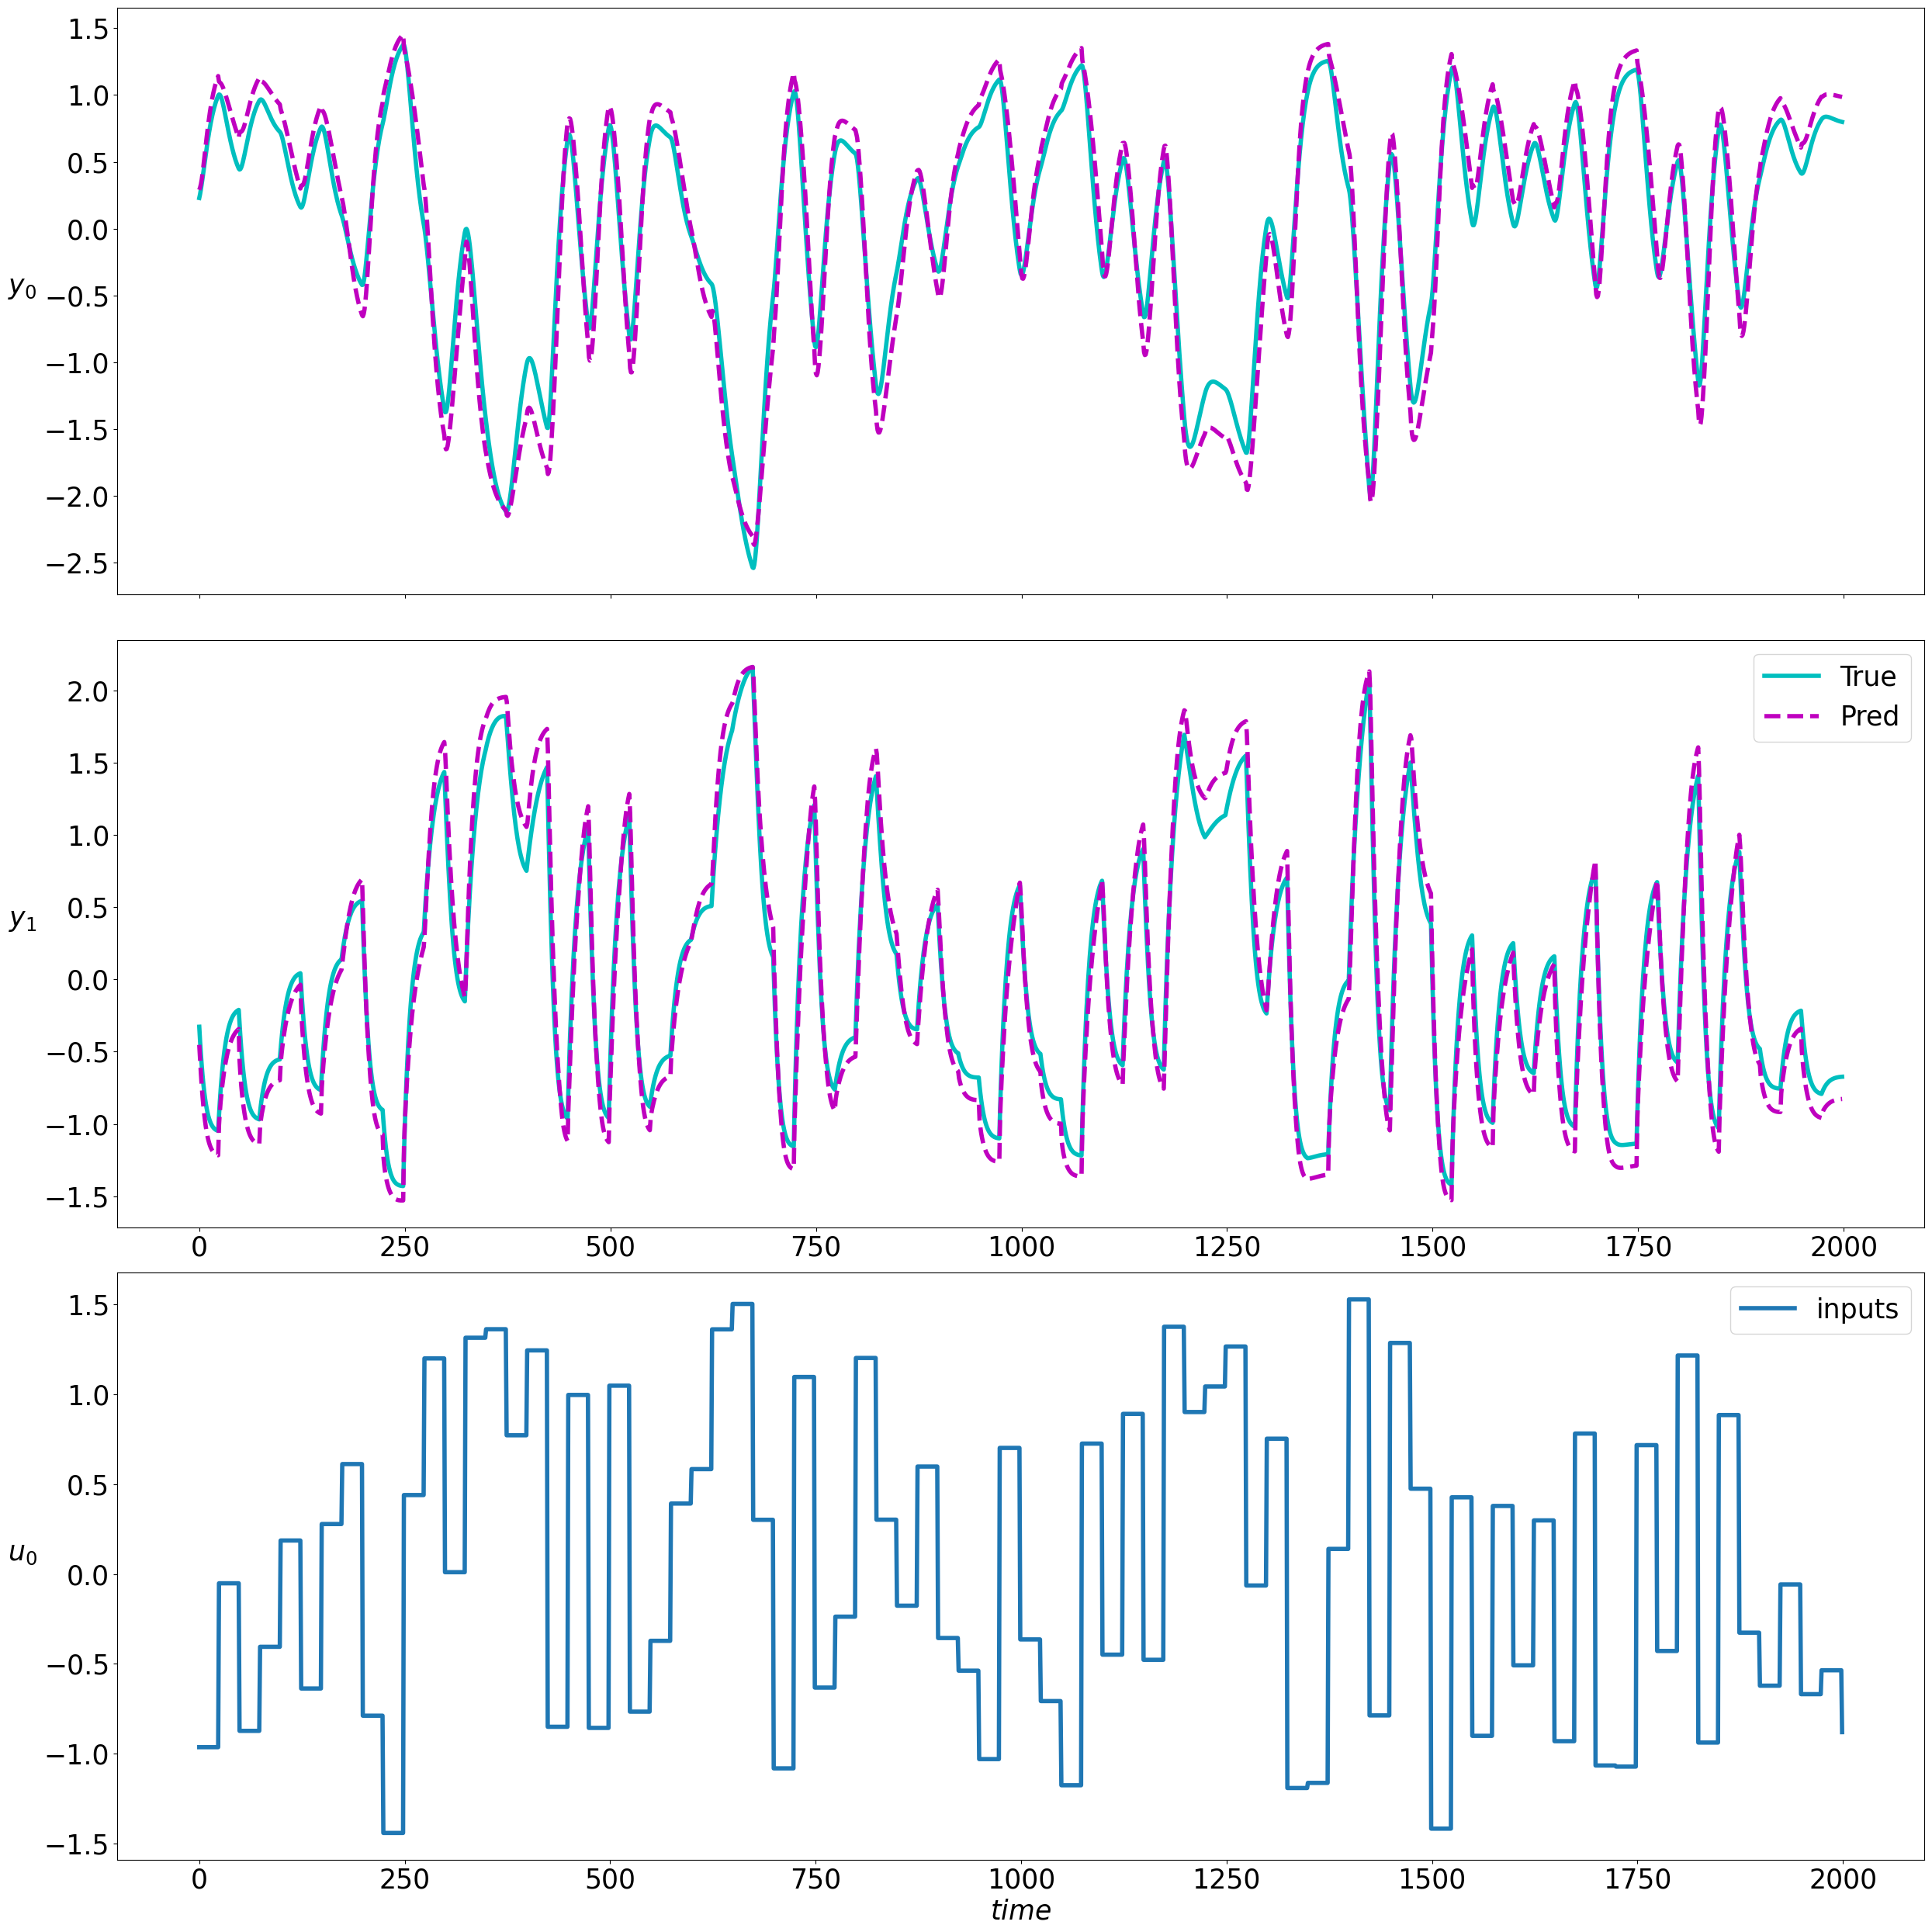

In [19]:
# plot trajectories
figsize = 25
fig, ax = plt.subplots(nx + nu, figsize=(figsize, figsize))

x_labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, x_labels)):
    axe = ax[row]
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, 'c', linewidth=4.0, label='True')
    axe.plot(t2, 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)

u_labels = [f'$u_{k}$' for k in range(len(input_traj))]
for row, (u, label) in enumerate(zip(input_traj, u_labels)):
    axe = ax[row+nx]
    axe.plot(u, linewidth=4.0, label='inputs')
    axe.legend(fontsize=figsize)
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.tick_params(labelbottom=True, labelsize=figsize)

ax[-1].set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()

In [20]:
# compute Koopman eigenvalues and eigenvectors
if stable:
    eig, eig_vec = torch.linalg.eig(K.effective_W())
else:
    eig, eig_vec = torch.linalg.eig(K.weight)
# Koopman eigenvalues real and imaginary parts
eReal = eig.real.detach().numpy()
eImag = eig.imag.detach().numpy()
# unit circle
t = np.linspace(0.0, 2 * np.pi, 1000)
x_circ = np.cos(t)
y_circ = np.sin(t)

Text(0.5, 0.98, 'Koopman operator eigenvalues')

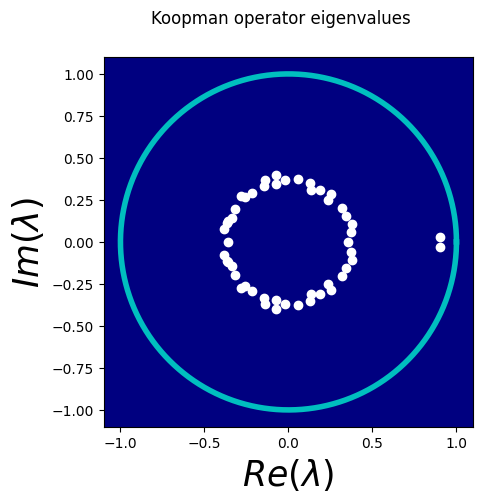

In [21]:
# plot Koopman eigenvalues
fig1, ax1 = plt.subplots()
ax1.plot(x_circ, y_circ, 'c', linewidth=4)
ax1.plot(eReal, eImag, 'wo')
ax1.set_aspect('equal', 'box')
ax1.set_facecolor("navy")
ax1.set_xlabel("$Re(\lambda)$", fontsize=figsize)
ax1.set_ylabel("$Im(\lambda)$", fontsize=figsize)
fig1.suptitle('Koopman operator eigenvalues')


In [24]:
# compute Koopman state eigenvectors
y_min = 1.1*test_data['Y'].min()
y_max = 1.1*test_data['Y'].max()
y1 = torch.linspace(y_min, y_max, 1000)
y2 = torch.linspace(y_min, y_max, 1000)
yy1, yy2 = torch.meshgrid(y1, y1)
plot_yy1 = yy1.detach().numpy()
plot_yy2 = yy2.detach().numpy()
# eigenvectors
features = torch.stack([yy1, yy2]).transpose(0, 2)
latent = f_y(features)
phi = torch.matmul(latent, abs(eig_vec))
# select first 6 eigenvectors
phi_1 = phi.detach().numpy()[:,:,0]
phi_2 = phi.detach().numpy()[:,:,1]
phi_3 = phi.detach().numpy()[:,:,2]
phi_4 = phi.detach().numpy()[:,:,3]
phi_5 = phi.detach().numpy()[:,:,4]
phi_6 = phi.detach().numpy()[:,:,6]


C:\Users\drgo694\OneDrive - PNNL\Documents\anaconda3\envs\neuromancer\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0.5, 0.98, 'first six eigenfunctions')

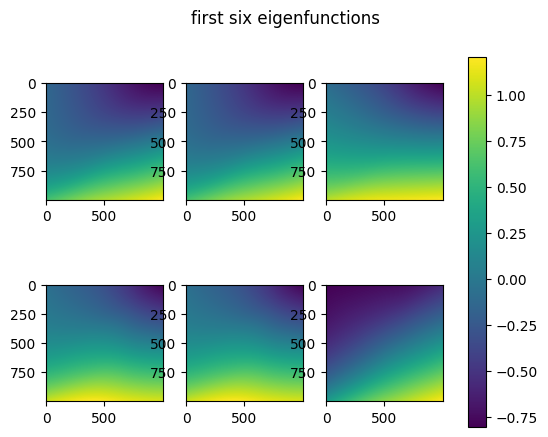

In [25]:
# plot eigenvectors
fig2, axs = plt.subplots(2, 3)
im1 = axs[0,0].imshow(phi_1)
im2 = axs[0,1].imshow(phi_2)
im3 = axs[0,2].imshow(phi_3)
im4 = axs[1,0].imshow(phi_4)
im5 = axs[1,1].imshow(phi_5)
im6 = axs[1,2].imshow(phi_6)
fig2.colorbar(im1, ax=axs)
fig2.suptitle('first six eigenfunctions')